In [23]:
# ==============================================================================
# 模块一：环境准备与数据加载 (适配新数据格式版)
# ==============================================================================
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from chinese_calendar import is_workday, is_holiday
from functools import partial
import json
import matplotlib.pyplot as plt
import seaborn as sns

# -- 配置绘图风格和中文显示 --
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# --- 1. 定义文件路径 ---
# 请确保文件名与上一步生成的保持一致
panel_data_path = r"E:\A智网\电量预测数据\lightgbm模型\133个行业电量天气对齐数据_1.26.csv"
full_weather_path = r"E:\A智网\电量预测数据\lightgbm模型\湖北省每日温度特征_1.26.xlsx"

# --- 2. 加载【历史】电量与天气面板数据 ---
try:
    print("--- 正在加载历史电量与天气面板数据 ---")
    # 【修改】上一步保存用的是 utf_8_sig，这里读取建议用 utf-8，如果报错再尝试 gbk
    try:
        df_main = pd.read_csv(panel_data_path, parse_dates=['date'], encoding='utf-8')
    except UnicodeDecodeError:
        df_main = pd.read_csv(panel_data_path, parse_dates=['date'], encoding='gbk')
        
    print("历史面板数据加载成功！")
    print("数据预览：")
    print(df_main.head())
except Exception as e:
    print(f"加载面板数据时出错: {e}")
    df_main = pd.DataFrame()

# --- 3. 加载并准备【完整天气】数据源 ---
try:
    print("\n--- 正在加载完整天气数据源 ---")
    df_weather_raw = pd.read_excel(full_weather_path)
    
        
    # 1. 寻找日期列
    date_col = None
    for col in df_weather_raw.columns:
        if '日期' in str(col) or 'date' in str(col).lower() or 'DATE' in str(col):
            date_col = col
            break
    
    # 如果找不到，尝试使用索引或者第一列
    if date_col is None:
        date_col = df_weather_raw.columns[0]
    
    # 2. 设置日期索引
    df_weather_full = df_weather_raw.set_index(date_col)
    df_weather_full.index.name = 'date'
    # 强制转换日期格式，处理可能的格式不一致
    df_weather_full.index = pd.to_datetime(df_weather_full.index, format='%Y%m%d', errors='coerce')
    
    # 删除日期转换失败的行（比如空行或表头说明）
    df_weather_full = df_weather_full[df_weather_full.index.notnull()]

    # 3. 重命名列 (去掉了标准差)
    rename_dict = {
        '日平均温度': 'temp_mean', 
        '日最高温度': 'temp_max', 
        '日最低温度': 'temp_min',
        '日温差': 'temp_range'
    }
    df_weather_full.rename(columns=rename_dict, inplace=True)
    
    # 4. 只保留需要的列，并确保是数值型
    needed_cols = ['temp_mean', 'temp_max', 'temp_min', 'temp_range']
    # 取交集，防止列名不匹配报错
    final_cols = [c for c in needed_cols if c in df_weather_full.columns]
    df_weather_full = df_weather_full[final_cols].astype(float)

    print("完整天气数据源加载成功！")
    print(df_weather_full.head())
    
except Exception as e:
    print(f"加载完整天气数据时出错: {e}")
    import traceback
    traceback.print_exc()
    df_weather_full = pd.DataFrame()

--- 正在加载历史电量与天气面板数据 ---
历史面板数据加载成功！
数据预览：
        行业名称       date  load_MWh  temp_mean  temp_max  temp_min  temp_range
0      客户用电量 2023-01-01 56,822.22       6.88      8.78      5.50        3.28
1  A、全行业用电合计 2023-01-01 39,712.42       6.88      8.78      5.50        3.28
2       第一产业 2023-01-01    811.93       6.88      8.78      5.50        3.28
3       第二产业 2023-01-01 25,598.10       6.88      8.78      5.50        3.28
4       第三产业 2023-01-01 13,302.38       6.88      8.78      5.50        3.28

--- 正在加载完整天气数据源 ---
完整天气数据源加载成功！
            temp_mean  temp_max  temp_min  temp_range
date                                                 
2023-01-01       6.88      8.78      5.50        3.28
2023-01-02       7.17      9.74      5.71        4.03
2023-01-03       5.71     11.35      1.35        9.99
2023-01-04       6.26     11.33      0.90       10.43
2023-01-05       8.43     11.24      6.41        4.83


In [24]:
# ==============================================================================
# 模块二：在工作日数据上进行滚动窗口异常检测 (支持手动定义日期类型)
# 输入: df_main
# 输出: df_main (增加了'is_outlier'列)
# ==============================================================================

# --- 1. 手动日期配置区域 ---
# 格式：'YYYY-MM-DD': True (代表工作日/调休上班), False (代表节假日/周末)
# 你可以在这里补充 2026 年的特殊日期
MANUAL_DATE_OVERRIDES = {
    # --- 2026年 元旦 ---
    '2026-01-01': False, # 元旦放假
    '2026-01-02': False,
    '2026-01-03': False,
    '2026-01-04': True,

    # --- 2026年 春节 (示例) ---
    '2026-02-17': False, # 除夕
    '2026-02-18': False, # 春节
    '2026-02-19': False,
    '2026-02-20': False,
    '2026-02-21': False,
    '2026-02-22': False,
    '2026-02-23': False,
    '2026-02-24': False,
    
    # --- 2026年 调休上班 (假设) ---
    # '2026-02-15': True, # 假设这天是周日但要上班
    # '2026-02-28': True, # 假设这天是周六但要上班
}

def flag_outliers_on_workdays(df, industry_col='行业名称', value_col='load_MWh', date_col='date', window_size=31, factor=2.5):
    print("\n" + "="*50)
    print("      开始执行：工作日滚动窗口异常检测 (含手动日期修正)")
    print("="*50)
    df_flagged = df.copy()
    df_flagged['is_outlier'] = 0
    
    # --- 定义混合判断函数 ---
    def safe_is_workday(date_val):
        # 1. 【最高优先级】检查手动配置
        # 将日期转为字符串格式 'YYYY-MM-DD'
        date_str = date_val.strftime('%Y-%m-%d')
        if date_str in MANUAL_DATE_OVERRIDES:
            return MANUAL_DATE_OVERRIDES[date_str]
            
        # 2. 【次级优先级】尝试使用库判断
        try:
            return is_workday(date_val)
        except NotImplementedError:
            # 3. 【保底方案】如果库不支持该年份，使用周一至周五判断
            # weekday(): 0=周一, 4=周五, 5=周六, 6=周日
            return date_val.weekday() <= 4
        except Exception:
            return True # 其他异常默认视为工作日

    # 应用判断逻辑
    print("正在识别工作日...")
    workday_mask = df_flagged[date_col].apply(safe_is_workday)
    
    # 打印一下识别出的非工作日数量，确认配置是否生效
    non_workdays_count = (~workday_mask).sum()
    print(f"识别出非工作日(节假日/周末)数量: {non_workdays_count} 天")

    industries = df_flagged[industry_col].unique()
    total_outliers_found = 0
    
    for industry in industries:
        industry_workday_mask = (df_flagged[industry_col] == industry) & workday_mask
        series = df_flagged.loc[industry_workday_mask, value_col]
        
        if len(series) < 20: continue
        
        rolling_q1 = series.rolling(window=window_size, center=True, min_periods=window_size//2).quantile(0.25)
        rolling_q3 = series.rolling(window=window_size, center=True, min_periods=window_size//2).quantile(0.75)
        rolling_iqr = rolling_q3 - rolling_q1
        
        lower_bound = rolling_q1 - (rolling_iqr * factor)
        upper_bound = rolling_q3 + (rolling_iqr * factor)
        
        outlier_mask = (series < lower_bound) | (series > upper_bound)
        outlier_indices = series[outlier_mask].index
        
        df_flagged.loc[outlier_indices, 'is_outlier'] = 1
        total_outliers_found += outlier_mask.sum()
        
    print(f"\n处理完成！总共在【工作日】数据中标记了 {total_outliers_found} 个统计异常点。")
    return df_flagged

if 'df_main' in locals() and not df_main.empty:
    df_main = flag_outliers_on_workdays(df_main)
    print("主DataFrame 'df_main' 已被添加了'is_outlier'特征的数据覆盖。")
else:
    print("错误：'df_main' 未加载，无法进行异常处理。")


      开始执行：工作日滚动窗口异常检测 (含手动日期修正)
正在识别工作日...
识别出非工作日(节假日/周末)数量: 47838 天

处理完成！总共在【工作日】数据中标记了 726 个统计异常点。
主DataFrame 'df_main' 已被添加了'is_outlier'特征的数据覆盖。


In [25]:
# ==============================================================================
# 模块三：严格的时序划分 (在特征工程之前)
# 输入: df_main
# 输出: historical_df, test_df
# ==============================================================================
if 'df_main' in locals() and not df_main.empty:
    test_start_date = df_main['date'].max() - pd.DateOffset(days=29)
    
    historical_df = df_main[df_main['date'] < test_start_date].copy()
    test_df = df_main[df_main['date'] >= test_start_date].copy()

    print("\n--- 数据集已严格划分为历史集和测试集 ---")
    print(f"  历史数据 (historical_df): {len(historical_df)} 行, 截止到 {historical_df['date'].max().date()}")
    print(f"  最终测试集 (test_df): {len(test_df)} 行, 从 {test_start_date.date()} 开始")
else:
    print("错误：'df_main' 未加载，无法进行数据划分。")


--- 数据集已严格划分为历史集和测试集 ---
  历史数据 (historical_df): 146194 行, 截止到 2025-12-26
  最终测试集 (test_df): 4020 行, 从 2025-12-27 开始


In [26]:
# ==============================================================================
# 模块四 & 五 (最终版 - 恢复真实未来天气 - 适配新天气源): 特征工程、敏感度分析与模型分层
# ==============================================================================

# --- 4a. 定义【终极版】特征工程函数 (逻辑重构，适配新天气源) ---
def create_panel_features_ultimate(df_input, df_weather_source):
    """
    终极版特征工程函数 (恢复使用真实的未来天气数据)
    警告：此函数使用了未来的真实数据(shift(-N))，用于探索模型性能上限。
    此函数期望输入的 df_input 中已经包含了 'sensitivity' 列。
    """
    print("\n--- 正在执行终极版特征工程 (使用真实未来天气) ---")
    
    df_proc = df_input.copy()
    
    # --- 1. 创建基础特征 (与你的版本完全一致) ---
    df_proc = df_proc.sort_values(by=['行业名称', 'date']).reset_index(drop=True)
    print("正在创建历史和日历相关特征...")
    df_proc['month'] = df_proc['date'].dt.month
    df_proc['dayofweek'] = df_proc['date'].dt.dayofweek
    df_proc['dayofyear'] = df_proc['date'].dt.dayofyear
    df_proc['weekofyear'] = df_proc['date'].dt.isocalendar().week.astype(int)
    df_proc['is_holiday'] = df_proc['date'].apply(is_holiday).astype(int)
    df_proc['is_weekend_norm'] = (df_proc['date'].dt.dayofweek >= 5).astype(int)
    df_proc['is_adj_workday'] = df_proc.apply(lambda row: 1 if is_workday(row['date']) and row['dayofweek'] >= 5 else 0, axis=1)
    df_proc['is_offday'] = df_proc.apply(lambda row: 1 if row['is_holiday'] == 1 or (row['is_weekend_norm'] == 1 and row['is_adj_workday'] == 0) else 0, axis=1)
    lags = [1, 2, 7, 14]
    for lag in lags:
        df_proc[f'load_lag_{lag}'] = df_proc.groupby('行业名称')['load_MWh'].shift(lag)
    df_proc['rolling_mean_7'] = df_proc.groupby('行业名称')['load_MWh'].shift(1).rolling(window=7, min_periods=1).mean()
    df_proc['rolling_std_7'] = df_proc.groupby('行业名称')['load_MWh'].shift(1).rolling(window=7, min_periods=1).std()
    df_proc['load_diff_1_7'] = df_proc['load_lag_1'] - df_proc['load_lag_7']
    df_proc['load_ratio_1_roll7'] = (df_proc['load_lag_1'] / (df_proc['rolling_mean_7'] + 1e-6)) - 1
    
    # --- 2. 【核心恢复】使用 shift(-N) 和 merge 创建【真实】未来天气特征 ---
    print("正在创建【交互式】的真实未来天气特征...")
    
    future_days = [1, 2, 3]
    # 确保只使用存在的列
    available_weather_cols = [c for c in ['temp_mean', 'temp_max', 'temp_min'] if c in df_weather_source.columns]
    
    if not available_weather_cols:
        print("警告：未找到预期的天气列 (temp_mean, temp_max, temp_min)，跳过天气特征生成。")
    else:
        # a) 准备包含所有未来天气的临时天气表
        #    df_weather_source 已经是日期索引，直接 shift 即可
        df_weather_features_to_add = pd.DataFrame(index=df_weather_source.index)
        
        for day in future_days:
            for col in available_weather_cols:
                # shift(-day) 表示向上移动，即获取未来的数据
                col_name = f'{col}_future_d{day}'
                df_weather_features_to_add[col_name] = df_weather_source[col].shift(-day)
                
        # b) 将这个准备好的天气特征表，合并到主数据中
        #    使用 left_on='date' 和 right_index=True
        df_proc = pd.merge(df_proc, df_weather_features_to_add, left_on='date', right_index=True, how='left')
        
        # c) 在合并之后，再创建交互特征
        if 'sensitivity' not in df_proc.columns:
            raise ValueError("错误: 输入的DataFrame中必须包含 'sensitivity' 列才能创建交互特征！")
            
        for day in future_days:
            for col in available_weather_cols:
                future_col = f'{col}_future_d{day}'
                if future_col in df_proc.columns:
                    df_proc[f'{future_col}_high_sens'] = df_proc[future_col] * (df_proc['sensitivity'] == '高敏感')
                    df_proc[f'{future_col}_low_sens'] = df_proc[future_col] * (df_proc['sensitivity'] == '低敏感')
                    # 删除原始的未来天气列，只保留交互特征
                    df_proc = df_proc.drop(columns=[future_col])

    print("交互式未来天气特征创建完成！")

    # --- 3. 清理与返回 ---
    df_proc['行业名称'] = df_proc['行业名称'].astype('category')
    df_proc = df_proc.drop(['is_weekend_norm', 'is_adj_workday'], axis=1)
    
    return df_proc

# --- 5a. 在【纯净历史数据】上进行天气敏感度分析 ---
if 'historical_df' in locals():
    # 【强化】主动清理任何残留的sensitivity列，防止重复运行时出错
    cols_to_drop = ['sensitivity', 'sensitivity_x', 'sensitivity_y']
    for col in cols_to_drop:
        if col in historical_df.columns:
            historical_df = historical_df.drop(columns=[col])
            print(f"检测到并移除了残留的 '{col}' 列。")

    print("\n--- 正在【纯净历史数据】上进行天气敏感度分析 ---")
    # 确保 temp_max 存在
    if 'temp_max' in historical_df.columns:
        correlations = historical_df.groupby('行业名称')[['load_MWh', 'temp_max']].corr().unstack().iloc[:, 1]
        def assign_sensitivity(corr_value):
            if corr_value is not None and corr_value > 0.4: return '高敏感'
            else: return '低敏感'
        sensitivity_df = correlations.to_frame('correlation')
        sensitivity_df['sensitivity'] = sensitivity_df['correlation'].apply(assign_sensitivity)
        
        # --- 5b. 【核心】为 historical_df 添加敏感度标签 ---
        historical_df = pd.merge(historical_df, sensitivity_df[['sensitivity']], left_on='行业名称', right_index=True, how='left')
        historical_df['sensitivity'] = historical_df['sensitivity'].fillna('低敏感')
        print("天气敏感度分析完成，并已将标签添加到historical_df。")
    else:
        print("警告：historical_df 中缺少 'temp_max' 列，跳过敏感度分析，默认全为低敏感。")
        historical_df['sensitivity'] = '低敏感'
else:
    print("错误：'historical_df'不存在，无法进行敏感度分析。")

# --- 5c. 【核心】对【添加了敏感度标签】的历史数据，进行终极版特征工程 ---
if 'historical_df' in locals() and 'df_weather_full' in locals():
    # 严格使用你已有的函数名和变量名
    df_featured_historical = create_panel_features_ultimate(historical_df, df_weather_full)
    
    # 在特征工程后，再把不再需要的 sensitivity 列删掉
    if 'sensitivity' in df_featured_historical.columns:
        df_featured_historical = df_featured_historical.drop(columns=['sensitivity'])
        
    df_featured_historical = df_featured_historical.dropna()
else:
    print("错误：缺少必要数据，无法进行特征工程。")

# --- 5d. 在【特征化后】的历史数据上进行模型分层 ---
if 'df_featured_historical' in locals():
    print("\n--- 正在进行模型分层 ---")
    # 使用原始的 historical_df 计算均值，避免特征工程的影响
    industry_avg_load = historical_df.groupby('行业名称')['load_MWh'].mean().to_frame('avg_load')
    def assign_tier(avg_load):
        if avg_load >= 1000: return '大行业'
        elif avg_load < 100: return '小行业'
        else: return '中行业'
    industry_avg_load['tier'] = industry_avg_load['avg_load'].apply(assign_tier)
    df_featured_historical = pd.merge(df_featured_historical, industry_avg_load[['tier']], on='行业名称', how='left')
    df_featured_historical['tier'] = df_featured_historical['tier'].fillna('小行业')

    # --- 5e. 创建最终用于训练和调优的分层字典 ---
    data_tiers_hist = {
        '大行业': df_featured_historical[df_featured_historical['tier'] == '大行业'].copy(),
        '中行业': df_featured_historical[df_featured_historical['tier'] == '中行业'].copy(),
        '小行业': df_featured_historical[df_featured_historical['tier'] == '小行业'].copy()
    }
    print("分层数据集 'data_tiers_hist' 创建成功！")
else:
    print("错误：'df_featured_historical'不存在，无法进行模型分层。")


--- 正在【纯净历史数据】上进行天气敏感度分析 ---
天气敏感度分析完成，并已将标签添加到historical_df。

--- 正在执行终极版特征工程 (使用真实未来天气) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！

--- 正在进行模型分层 ---
分层数据集 'data_tiers_hist' 创建成功！


In [27]:
# ==============================================================================
# 模块四 & 五 (最终版 - 恢复真实未来天气 - 适配新天气源 - 集成手动节假日配置): 
# 特征工程、敏感度分析与模型分层
# ==============================================================================

# --- 0. 手动日期配置 (与模块二保持一致) ---
# 格式：'YYYY-MM-DD': True (工作/上班), False (休息/节假日)
MANUAL_DATE_OVERRIDES = {
# --- 2026年 元旦 ---
    '2026-01-01': False, # 元旦放假
    '2026-01-02': False,
    '2026-01-03': False,
    '2026-01-04': True,

    # --- 2026年 春节 (示例) ---
    '2026-02-17': False, # 除夕
    '2026-02-18': False, # 春节
    '2026-02-19': False,
    '2026-02-20': False,
    '2026-02-21': False,
    '2026-02-22': False,
    '2026-02-23': False,
    '2026-02-24': False,
    
    # --- 2026年 调休上班 (假设) ---
    # '2026-02-15': True, # 假设这天是周日但要上班
    # '2026-02-28': True, # 假设这天是周六但要上班
}

# --- 4a. 定义【终极版】特征工程函数 ---
def create_panel_features_ultimate(df_input, df_weather_source):
    """
    终极版特征工程函数 (集成手动节假日配置)
    """
    print("\n--- 正在执行终极版特征工程 (含手动节假日修正) ---")
    
    df_proc = df_input.copy()
    
    # --- 定义高优先级的判断函数 ---
    def safe_is_workday(date_val):
        # 1. 查字典 (最高优先级)
        date_str = date_val.strftime('%Y-%m-%d')
        if date_str in MANUAL_DATE_OVERRIDES:
            return MANUAL_DATE_OVERRIDES[date_str]
        
        # 2. 查库
        try:
            return is_workday(date_val)
        except NotImplementedError:
            # 3. 兜底
            return date_val.weekday() <= 4
        except Exception:
            return True

    def safe_is_holiday(date_val):
        # 1. 查字典 (最高优先级)
        # 注意：字典里 False 代表休息(可能是节假日或周末)，True 代表上班
        # 这里我们简单地将“休息”视为 holiday=1
        date_str = date_val.strftime('%Y-%m-%d')
        if date_str in MANUAL_DATE_OVERRIDES:
            return not MANUAL_DATE_OVERRIDES[date_str]
            
        # 2. 查库
        try:
            return is_holiday(date_val)
        except NotImplementedError:
            # 3. 兜底
            return date_val.weekday() >= 5
        except Exception:
            return False

    # --- 1. 创建基础特征 ---
    df_proc = df_proc.sort_values(by=['行业名称', 'date']).reset_index(drop=True)
    print("正在创建历史和日历相关特征...")
    df_proc['month'] = df_proc['date'].dt.month
    df_proc['dayofweek'] = df_proc['date'].dt.dayofweek
    df_proc['dayofyear'] = df_proc['date'].dt.dayofyear
    df_proc['weekofyear'] = df_proc['date'].dt.isocalendar().week.astype(int)
    
    # 使用增强版函数
    df_proc['is_holiday'] = df_proc['date'].apply(safe_is_holiday).astype(int)
    
    df_proc['is_weekend_norm'] = (df_proc['date'].dt.dayofweek >= 5).astype(int)
    
    # 使用增强版函数判断调休
    # 逻辑：如果是手动定义的上班日(True) 且 它是周末(>=5)，则为调休上班
    df_proc['is_adj_workday'] = df_proc.apply(lambda row: 1 if safe_is_workday(row['date']) and row['dayofweek'] >= 5 else 0, axis=1)
    
    df_proc['is_offday'] = df_proc.apply(lambda row: 1 if row['is_holiday'] == 1 or (row['is_weekend_norm'] == 1 and row['is_adj_workday'] == 0) else 0, axis=1)
    
    lags = [1, 2, 7, 14]
    for lag in lags:
        df_proc[f'load_lag_{lag}'] = df_proc.groupby('行业名称')['load_MWh'].shift(lag)
    df_proc['rolling_mean_7'] = df_proc.groupby('行业名称')['load_MWh'].shift(1).rolling(window=7, min_periods=1).mean()
    df_proc['rolling_std_7'] = df_proc.groupby('行业名称')['load_MWh'].shift(1).rolling(window=7, min_periods=1).std()
    df_proc['load_diff_1_7'] = df_proc['load_lag_1'] - df_proc['load_lag_7']
    df_proc['load_ratio_1_roll7'] = (df_proc['load_lag_1'] / (df_proc['rolling_mean_7'] + 1e-6)) - 1
    
    # --- 2. 创建未来天气特征 (适配新天气源) ---
    print("正在创建【交互式】的真实未来天气特征...")
    
    future_days = [1, 2, 3]
    available_weather_cols = [c for c in ['temp_mean', 'temp_max', 'temp_min'] if c in df_weather_source.columns]
    
    if not available_weather_cols:
        print("警告：未找到预期的天气列，跳过天气特征生成。")
    else:
        df_weather_features_to_add = pd.DataFrame(index=df_weather_source.index)
        for day in future_days:
            for col in available_weather_cols:
                col_name = f'{col}_future_d{day}'
                df_weather_features_to_add[col_name] = df_weather_source[col].shift(-day)
                
        df_proc = pd.merge(df_proc, df_weather_features_to_add, left_on='date', right_index=True, how='left')
        
        if 'sensitivity' not in df_proc.columns:
            raise ValueError("错误: 输入的DataFrame中必须包含 'sensitivity' 列！")
            
        for day in future_days:
            for col in available_weather_cols:
                future_col = f'{col}_future_d{day}'
                if future_col in df_proc.columns:
                    df_proc[f'{future_col}_high_sens'] = df_proc[future_col] * (df_proc['sensitivity'] == '高敏感')
                    df_proc[f'{future_col}_low_sens'] = df_proc[future_col] * (df_proc['sensitivity'] == '低敏感')
                    df_proc = df_proc.drop(columns=[future_col])

    print("交互式未来天气特征创建完成！")

    # --- 3. 清理与返回 ---
    df_proc['行业名称'] = df_proc['行业名称'].astype('category')
    df_proc = df_proc.drop(['is_weekend_norm', 'is_adj_workday'], axis=1)
    
    return df_proc

# --- 5a. 在【纯净历史数据】上进行天气敏感度分析 ---
if 'historical_df' in locals():
    cols_to_drop = ['sensitivity', 'sensitivity_x', 'sensitivity_y']
    for col in cols_to_drop:
        if col in historical_df.columns:
            historical_df = historical_df.drop(columns=[col])
            print(f"检测到并移除了残留的 '{col}' 列。")

    print("\n--- 正在【纯净历史数据】上进行天气敏感度分析 ---")
    if 'temp_max' in historical_df.columns:
        correlations = historical_df.groupby('行业名称')[['load_MWh', 'temp_max']].corr().unstack().iloc[:, 1]
        def assign_sensitivity(corr_value):
            if corr_value is not None and corr_value > 0.4: return '高敏感'
            else: return '低敏感'
        sensitivity_df = correlations.to_frame('correlation')
        sensitivity_df['sensitivity'] = sensitivity_df['correlation'].apply(assign_sensitivity)
        
        historical_df = pd.merge(historical_df, sensitivity_df[['sensitivity']], left_on='行业名称', right_index=True, how='left')
        historical_df['sensitivity'] = historical_df['sensitivity'].fillna('低敏感')
        print("天气敏感度分析完成。")
    else:
        print("警告：缺少 'temp_max' 列，默认全为低敏感。")
        historical_df['sensitivity'] = '低敏感'
else:
    print("错误：'historical_df'不存在。")

# --- 5c. 【核心】对【添加了敏感度标签】的历史数据，进行终极版特征工程 ---
if 'historical_df' in locals() and 'df_weather_full' in locals():
    df_featured_historical = create_panel_features_ultimate(historical_df, df_weather_full)
    
    if 'sensitivity' in df_featured_historical.columns:
        df_featured_historical = df_featured_historical.drop(columns=['sensitivity'])
        
    df_featured_historical = df_featured_historical.dropna()
else:
    print("错误：缺少必要数据，无法进行特征工程。")

# --- 5d. 在【特征化后】的历史数据上进行模型分层 ---
if 'df_featured_historical' in locals():
    print("\n--- 正在进行模型分层 ---")
    industry_avg_load = historical_df.groupby('行业名称')['load_MWh'].mean().to_frame('avg_load')
    def assign_tier(avg_load):
        if avg_load >= 1000: return '大行业'
        elif avg_load < 100: return '小行业'
        else: return '中行业'
    industry_avg_load['tier'] = industry_avg_load['avg_load'].apply(assign_tier)
    df_featured_historical = pd.merge(df_featured_historical, industry_avg_load[['tier']], on='行业名称', how='left')
    df_featured_historical['tier'] = df_featured_historical['tier'].fillna('小行业')

    data_tiers_hist = {
        '大行业': df_featured_historical[df_featured_historical['tier'] == '大行业'].copy(),
        '中行业': df_featured_historical[df_featured_historical['tier'] == '中行业'].copy(),
        '小行业': df_featured_historical[df_featured_historical['tier'] == '小行业'].copy()
    }
    print("分层数据集 'data_tiers_hist' 创建成功！")
else:
    print("错误：'df_featured_historical'不存在。")

检测到并移除了残留的 'sensitivity' 列。

--- 正在【纯净历史数据】上进行天气敏感度分析 ---
天气敏感度分析完成。

--- 正在执行终极版特征工程 (含手动节假日修正) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！

--- 正在进行模型分层 ---
分层数据集 'data_tiers_hist' 创建成功！


In [ ]:
# ==============================================================================
# 模块六 (优化版)：为三个分层模型分别进行超参数调优
# 优化点：移除冗余类型转换，增强代码健壮性
# ==============================================================================
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_absolute_error
from functools import partial
import json
import pandas as pd

best_params_per_tier = {}

if 'data_tiers_hist' in locals() and data_tiers_hist:
    print("\n" + "="*50)
    print("      开始为三个层级的模型进行自动化超参数调优")
    print("="*50)

    def objective(trial, X_train, y_train, X_val, y_val):
        # --- 优化点：移除此处重复的 astype('category') 操作 ---
        # 因为在模块五最后我们已经处理过数据类型了，这里直接使用即可
        
        params = {
            'objective': 'regression_l1', # 使用 MAE 作为目标函数
            'metric': 'l1',
            'n_estimators': 3000,
            'random_state': 42,
            'n_jobs': -1, 
            'verbosity': -1,
            # --- 搜索空间 ---
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 200),
            'max_depth': trial.suggest_int('max_depth', 4, 12), # 稍微放宽深度上限
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0), # bagging_fraction 的别名
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), # feature_fraction 的别名
            'subsample_freq': trial.suggest_int('subsample_freq', 1, 7), # bagging_freq 的别名
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # lambda_l1 的别名
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # lambda_l2 的别名
        }
        
        # 使用 LightGBM 的 Scikit-learn API
        model = lgb.LGBMRegressor(**params)
        
        # 显式指定 categorical_feature，虽然 LightGBM 通常能自动识别 category 类型，但显式指定更稳健
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)], 
            eval_metric='mae',
            callbacks=[lgb.early_stopping(100, verbose=False)],
            categorical_feature=['行业名称'] 
        )
        
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        return mae

    for tier_name, df_tier in data_tiers_hist.items():
        if df_tier.empty: 
            print(f"跳过【{tier_name}】：数据为空")
            continue
            
        print(f"\n--- 正在为【{tier_name}】模型寻找最优参数 ---")
        
        # 1. 动态确定验证集切分点 (最后60天作为验证集，用于调参)
        val_date_start = df_tier['date'].max() - pd.DateOffset(days=59)
        
        # 2. 数据切分
        train_df = df_tier[df_tier['date'] < val_date_start].copy()
        val_df = df_tier[df_tier['date'] >= val_date_start].copy()
        
        # 3. 特征选择 (自动适配模块四/五生成的所有新特征)
        # 排除非特征列
        cols_to_exclude = ['date', 'load_MWh', 'tier']
        # 额外检查：如果 sensitivity 列没删干净，也排除掉
        if 'sensitivity' in df_tier.columns:
            cols_to_exclude.append('sensitivity')
            
        FEATURES = [col for col in df_tier.columns if col not in cols_to_exclude]
        
        print(f"  使用特征数量: {len(FEATURES)}")
        
        X_train, y_train = train_df[FEATURES], train_df['load_MWh']
        X_val, y_val = val_df[FEATURES], val_df['load_MWh']
        
        # 4. 执行 Optuna 优化
        # 使用 partial 固定数据参数，只让 optuna 传入 trial
        objective_with_data = partial(objective, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
        
        # 创建 study，设置随机种子复现结果
        sampler = optuna.samplers.TPESampler(seed=42)
        study = optuna.create_study(direction='minimize', sampler=sampler)
        
        # n_trials=50 是一个平衡点，如果时间充裕可设为 100
        study.optimize(objective_with_data, n_trials=50, show_progress_bar=True)
        
        best_params_per_tier[tier_name] = study.best_params
        print(f"【{tier_name}】最优 MAE: {study.best_value:.2f}")
        
    print("\n" + "="*50)
    print("      所有模型的超参数调优均已完成！")
    print("="*50)
    print("最终找到的各层级最优参数为：")
    print(json.dumps(best_params_per_tier, indent=4))

else:
    print("错误：未能找到'data_tiers_hist'字典，请检查模块四/五是否成功运行。")

In [28]:
# ==============================================================================
# 模块七 (最终版 - 非对称特征工程): 最终训练与无泄露评估
# ==============================================================================

# --- 0. 手动加载已知最优超参数 (MAE=91.1) ---
print("正在加载已知最优超参数...")
best_params_per_tier = {
    '大行业': {'learning_rate': 0.034002868380916096, 'num_leaves': 48, 'max_depth': 10, 'min_child_samples': 36, 'feature_fraction': 0.8655495783244953, 'bagging_fraction': 0.7136846508742616, 'bagging_freq': 7, 'lambda_l1': 0.0032244564626965682, 'lambda_l2': 4.603059648930217e-05},
    '中行业': {'learning_rate': 0.06288131356160809, 'num_leaves': 179, 'max_depth': 9, 'min_child_samples': 82, 'feature_fraction': 0.8859465064109061, 'bagging_fraction': 0.645748842980119, 'bagging_freq': 6, 'lambda_l1': 6.785845799108288e-06, 'lambda_l2': 9.943664916758198},
    '小行业': {'learning_rate': 0.02804580180260286, 'num_leaves': 228, 'max_depth': 9, 'min_child_samples': 68, 'feature_fraction': 0.9979956267652822, 'bagging_fraction': 0.9188841309431092, 'bagging_freq': 5, 'lambda_l1': 0.15471069640191787, 'lambda_l2': 0.4707028322072485}
}

# --- 1. 进行详细的前置变量检查 ---
print("\n--- 正在检查【模块七】所需的全部变量 ---")
required_vars = [
    'data_tiers_hist', 'historical_df', 'test_df', 
    'test_start_date', 'industry_avg_load', 'sensitivity_df', 'df_main', 'df_weather_full',
    'create_panel_features_ultimate'
]
missing_vars = [var for var in required_vars if var not in locals()]

if not missing_vars:
    print("所有必需的变量均已找到，准备开始最终训练与评估...")
    
    final_models = {}
    final_predictions = []

    print("\n" + "="*50)
    print("      开始使用【非对称特征集】进行最终训练")
    print("="*50)

    # 遍历【历史数据】分层字典进行训练
    for tier_name, df_tier_hist in data_tiers_hist.items():
        if df_tier_hist.empty: continue
        print(f"\n--- 正在处理【{tier_name}】模型 (最终训练) ---")
        
        # 1. 【核心：非对称特征工程】
        base_features = [col for col in df_tier_hist.columns if col not in ['date', 'load_MWh', 'tier']]
        
        if tier_name == '大行业':
            # 对于大行业，移除所有包含 "_future_d" 的特征
            features_to_use = [f for f in base_features if '_future_d' not in f]
            print(f"  -> 为【大行业】模型构建特征集，已移除未来天气特征，共 {len(features_to_use)} 个特征。")
        else:
            # 对于中小行业，使用全部特征
            features_to_use = base_features
            print(f"  -> 为【{tier_name}】模型构建特征集，使用全部可用特征，共 {len(features_to_use)} 个特征。")
            
        TARGET = 'load_MWh'
        
        # 使用 .copy() 避免 SettingWithCopyWarning
        X_train = df_tier_hist[features_to_use].copy()
        y_train = df_tier_hist[TARGET].copy()

        # 2. 加载最优参数并训练模型
        params = best_params_per_tier.get(tier_name, {})
        # 确保一些固定参数被设置
        params.update({
            'objective': 'regression_l1', 
            'random_state': 42,
            'n_jobs': -1, 
            'n_estimators': 5000,
            'verbosity': -1
        })
        model = lgb.LGBMRegressor(**params)
        
        print(f"开始在【全部历史数据】上训练【{tier_name}】模型...")
        X_train['行业名称'] = X_train['行业名称'].astype('category')
        model.fit(X_train, y_train, categorical_feature=['行业名称'])
        final_models[tier_name] = model
        print(f"【{tier_name}】模型训练完成。")
        
    # --- 在【从未见过】的测试集上进行最终评估 ---
    print("\n" + "="*50)
    print("      开始在最终测试集上进行无泄露评估")
    print("="*50)
    
    # 3. 为【完整的】测试集准备数据并创建【全部】特征
    test_df_to_process = test_df.copy()

    # 3a. 为测试集添加'sensitivity'标签，并先清理残留列
    if 'sensitivity_df' in locals():
        cols_to_drop = ['sensitivity', 'sensitivity_x', 'sensitivity_y']
        for col in cols_to_drop:
            if col in test_df_to_process.columns:
                test_df_to_process = test_df_to_process.drop(columns=[col])
        test_df_to_process = pd.merge(test_df_to_process, sensitivity_df[['sensitivity']], left_on='行业名称', right_index=True, how='left')
        test_df_to_process['sensitivity'] = test_df_to_process['sensitivity'].fillna('低敏感')
        print("已成功为测试集添加'sensitivity'标签。")
    else:
        raise ValueError("错误: 'sensitivity_df' 未找到，无法为测试集准备数据。")

    # 3b. 添加'tier'标签，并先清理残留列
    if 'tier' in test_df_to_process.columns:
        test_df_to_process = test_df_to_process.drop(columns=['tier'])
    test_df_to_process = pd.merge(test_df_to_process, industry_avg_load[['tier']], on='行业名称', how='left')
    test_df_to_process['tier'] = test_df_to_process['tier'].fillna('小行业')
    
    # 3c. 拼接历史数据尾部以计算滞后/滚动特征
    history_tail = historical_df.tail(30 * df_main['行业名称'].nunique())
    test_with_hist_tail = pd.concat([history_tail, test_df_to_process], ignore_index=True)
    
    # 3d. 调用我们修正后的特征工程函数
    df_featured_test = create_panel_features_ultimate(test_with_hist_tail, df_weather_full)
    if 'sensitivity' in df_featured_test.columns:
        df_featured_test = df_featured_test.drop(columns=['sensitivity'])
    df_featured_test = df_featured_test[df_featured_test['date'] >= test_start_date].copy()

    # 4. 使用训练好的模型，分层、并使用【对应的特征集】进行预测
    for tier_name, model in final_models.items():
        test_tier_df = df_featured_test[df_featured_test['tier'] == tier_name].copy()
        
        if not test_tier_df.empty:
            # 使用模型在训练时记住的特征列表来进行预测
            features_used_by_model = model.feature_name_
            
            # 检查测试集是否包含所有需要的特征
            missing_feats = [f for f in features_used_by_model if f not in test_tier_df.columns]
            if missing_feats:
                print(f"警告：【{tier_name}】测试集缺少特征: {missing_feats}")
                # 可以选择填充0或者报错，这里假设特征工程一致，不应缺失
            
            X_test_tier = test_tier_df[features_used_by_model].copy()
            X_test_tier['行业名称'] = X_test_tier['行业名称'].astype('category')
            
            test_tier_df['prediction'] = model.predict(X_test_tier)
            final_predictions.append(test_tier_df)

    # 5. 合并并评估
    if final_predictions:
        final_test_df = pd.concat(final_predictions)
        TARGET = 'load_MWh'
        overall_mae = mean_absolute_error(final_test_df[TARGET], final_test_df['prediction'])
        print("\n" + "-"*30)
        print(f"  【最终模型】整体 MAE: {overall_mae:,.2f}")
        print("-"*30)
    else:
        print("警告：未能生成任何预测结果。")

else:
    pri

正在加载已知最优超参数...

--- 正在检查【模块七】所需的全部变量 ---
所有必需的变量均已找到，准备开始最终训练与评估...

      开始使用【非对称特征集】进行最终训练

--- 正在处理【大行业】模型 (最终训练) ---
  -> 为【大行业】模型构建特征集，已移除未来天气特征，共 20 个特征。
开始在【全部历史数据】上训练【大行业】模型...
【大行业】模型训练完成。

--- 正在处理【中行业】模型 (最终训练) ---
  -> 为【中行业】模型构建特征集，使用全部可用特征，共 38 个特征。
开始在【全部历史数据】上训练【中行业】模型...
【中行业】模型训练完成。

--- 正在处理【小行业】模型 (最终训练) ---
  -> 为【小行业】模型构建特征集，使用全部可用特征，共 38 个特征。
开始在【全部历史数据】上训练【小行业】模型...
【小行业】模型训练完成。

      开始在最终测试集上进行无泄露评估
已成功为测试集添加'sensitivity'标签。

--- 正在执行终极版特征工程 (含手动节假日修正) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！

------------------------------
  【最终模型】整体 MAE: 112.88
------------------------------



      重点行业性能评估报告 (含准确率)
                所属模型层级     日均用电量  平均绝对误差 (MAE)  均方根误差 (RMSE)   MAPE 准确率 (1-WMAPE)
行业名称                                                                             
客户用电量              大行业 72,595.01      2,411.99      3,065.54  3.28%        96.68%
A、全行业用电合计          大行业 57,204.66      1,346.69      1,689.14  2.35%        97.65%
    第二产业           大行业 37,956.91      1,263.79      1,483.52  3.36%        96.67%
    第三产业           大行业 18,275.28        614.57        803.94  3.28%        96.64%
B、城乡居民生活用电合计       大行业 15,390.35        647.46        880.84  4.13%        95.79%
14.化学原料和化学制品制造业    大行业  5,579.02         85.20         98.65  1.52%        98.47%
15.医药制造业           中行业    811.24         27.27         38.75  3.53%        96.64%
18.非金属矿物制品业        大行业  3,664.02        108.68        146.74  3.07%        97.03%
19.黑色金属冶炼和压延加工业    大行业  2,911.41        130.60        165.01  4.45%        95.51%
20.有色金属冶炼和压延加工业    中行业    561.09         17.97         23.47  3.36%      

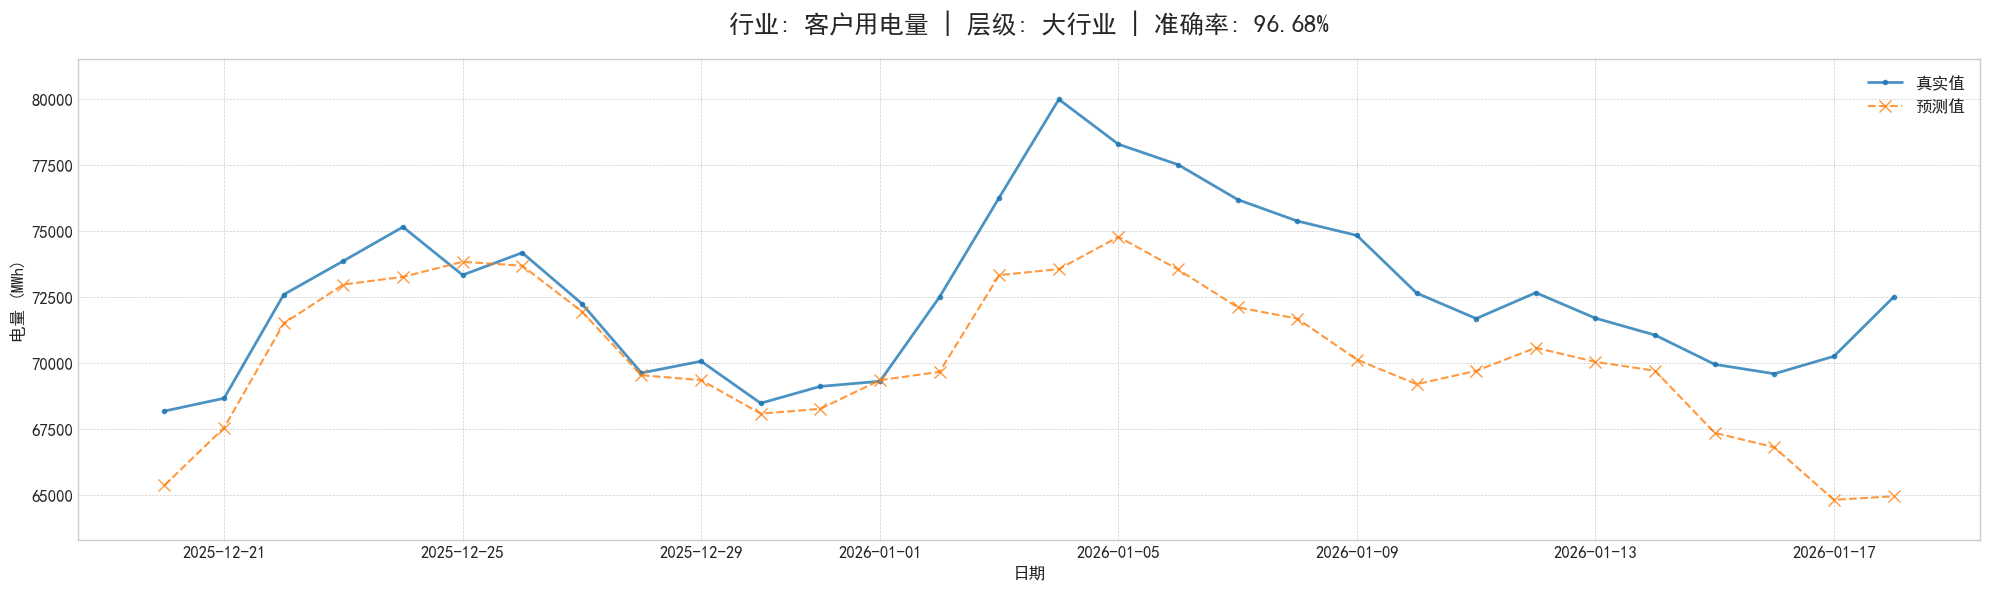

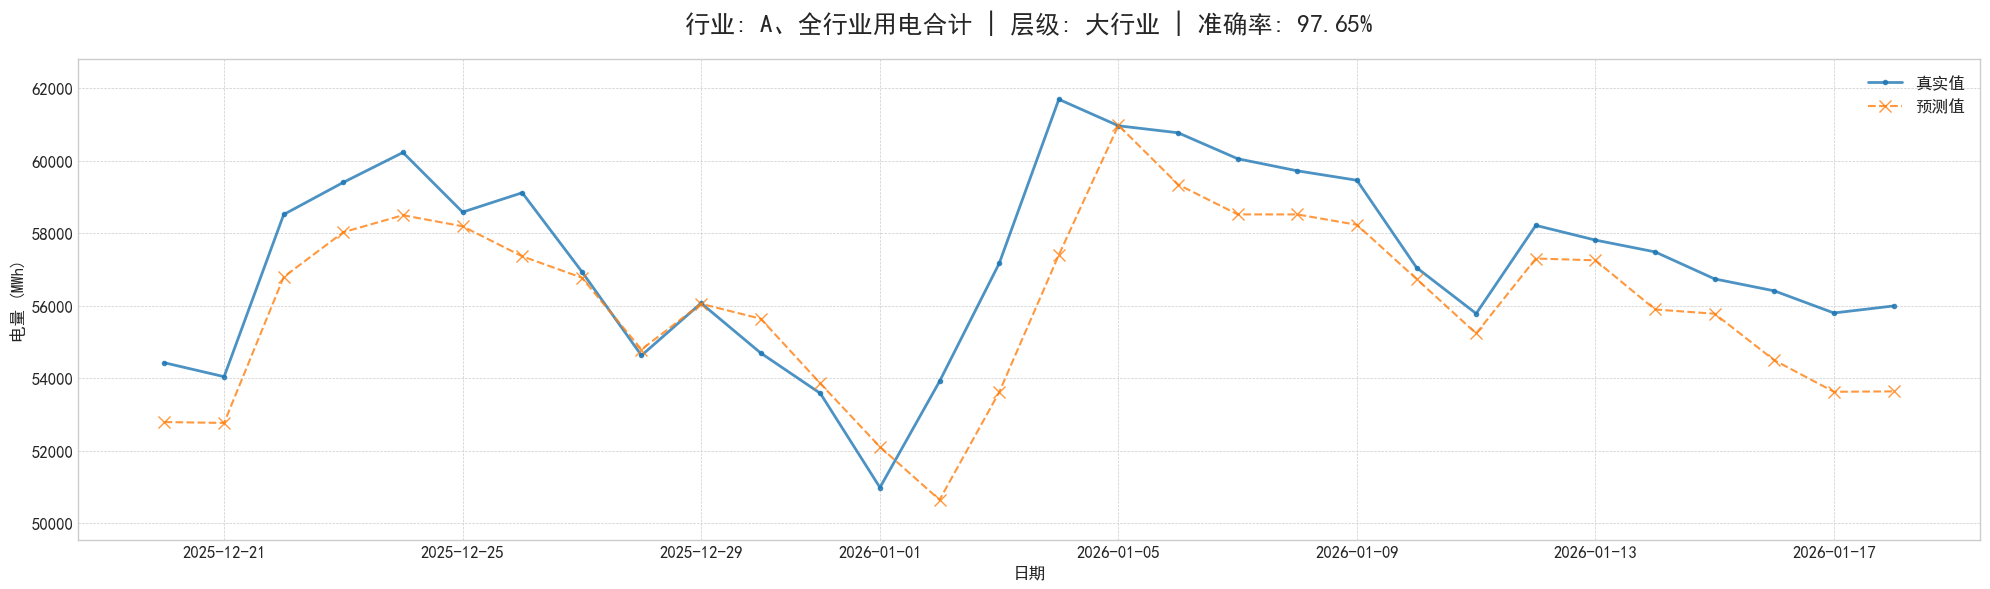

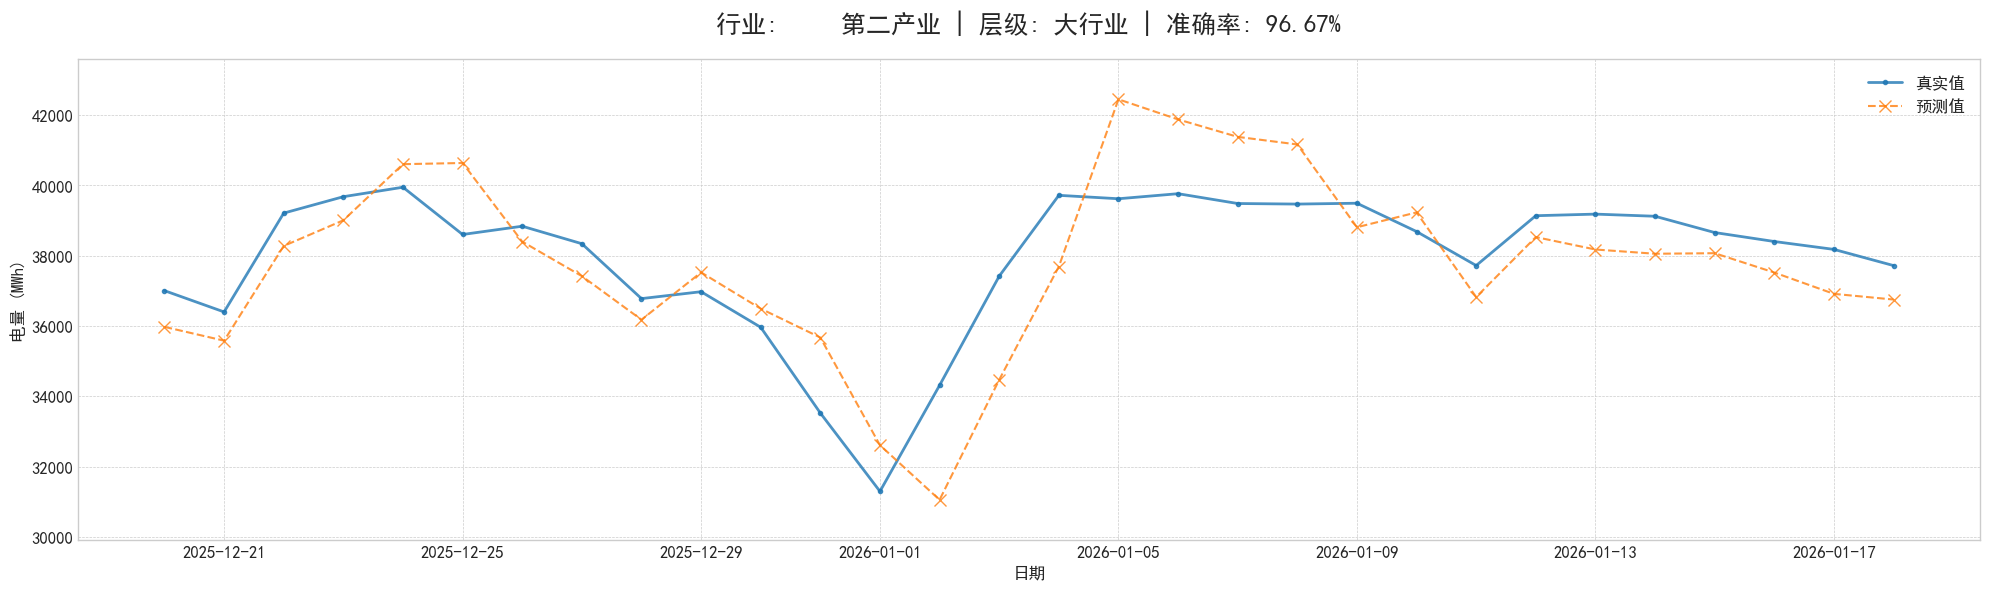

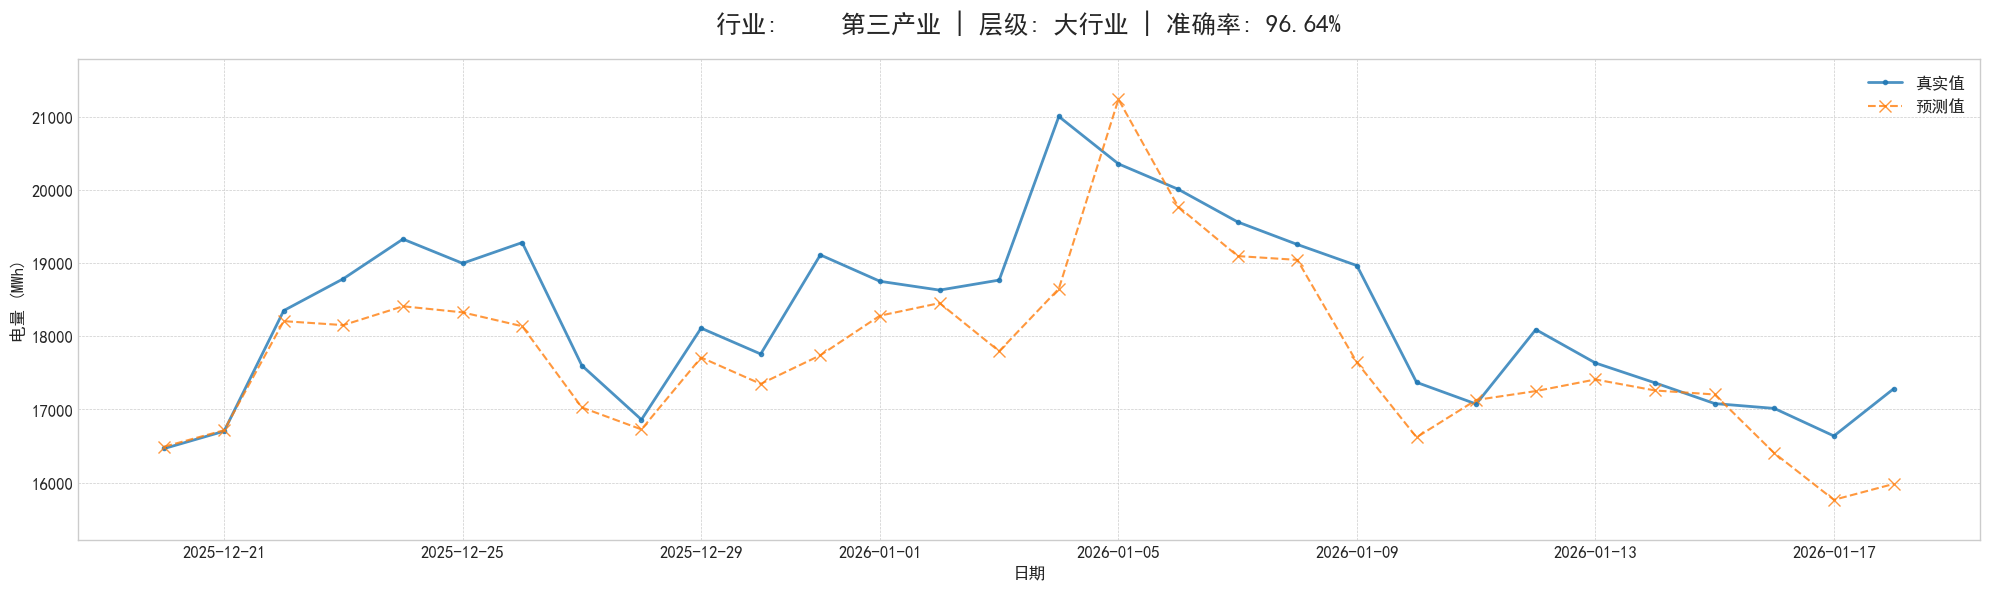

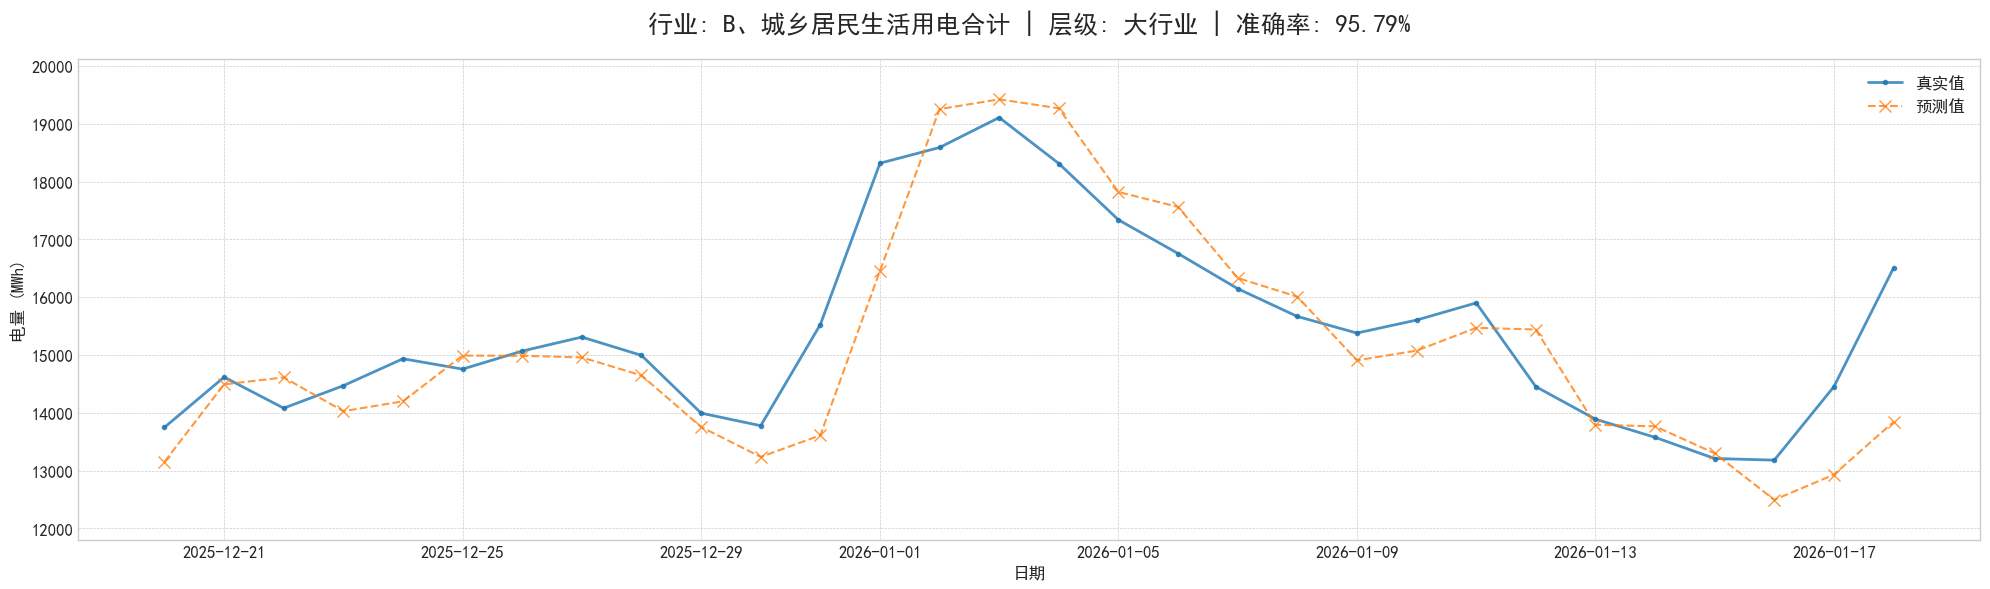

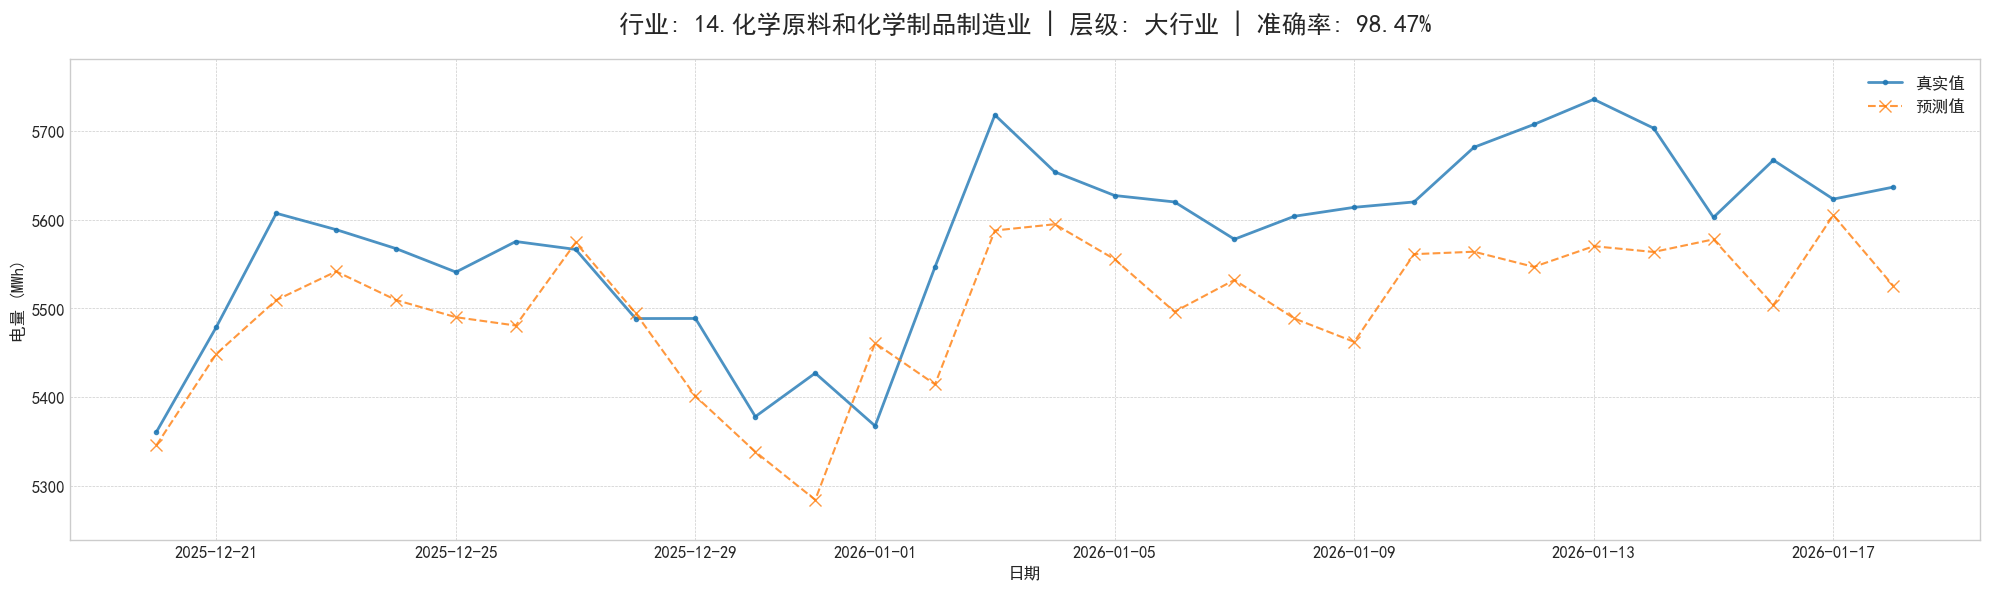

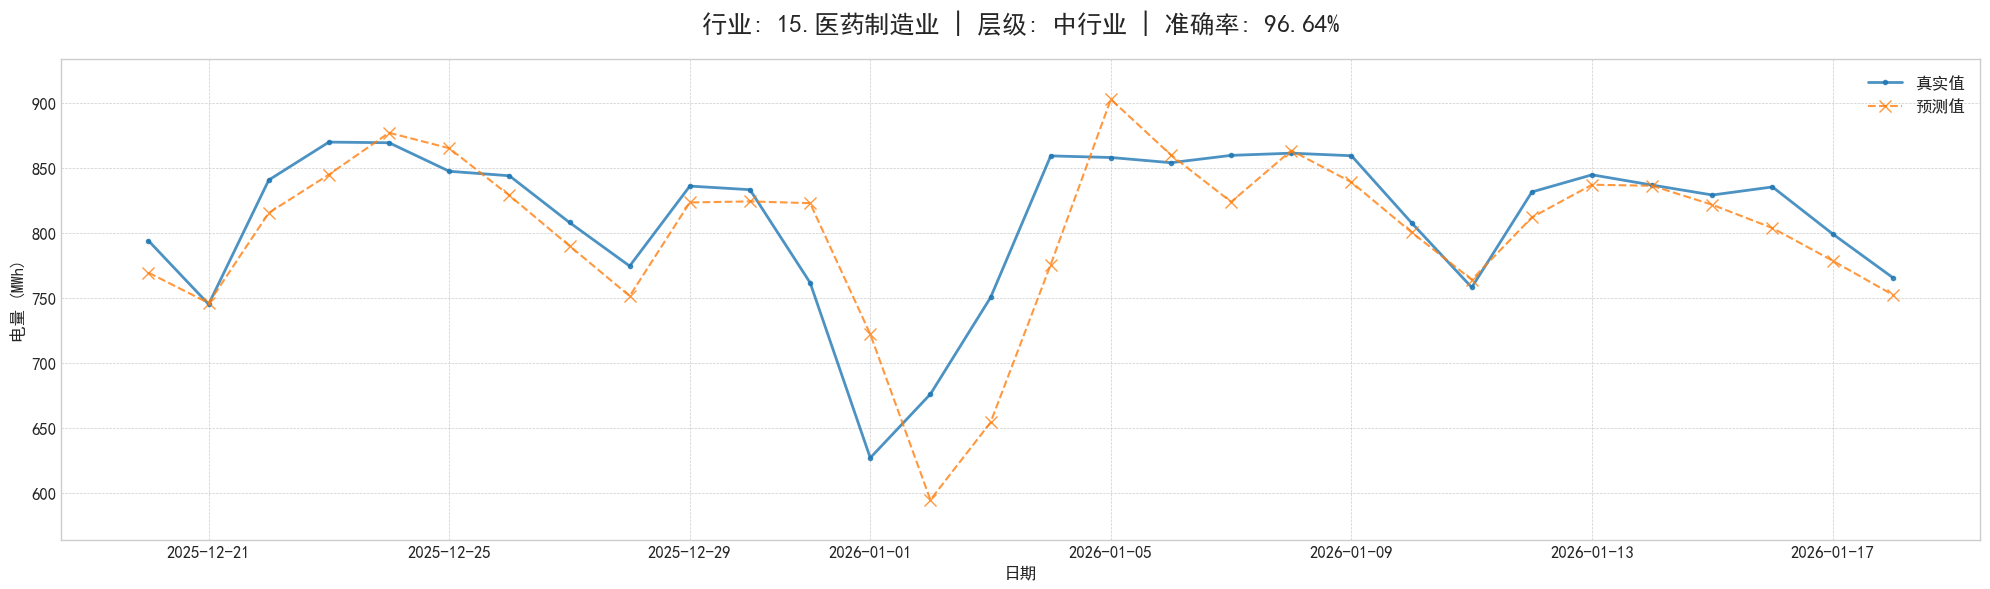

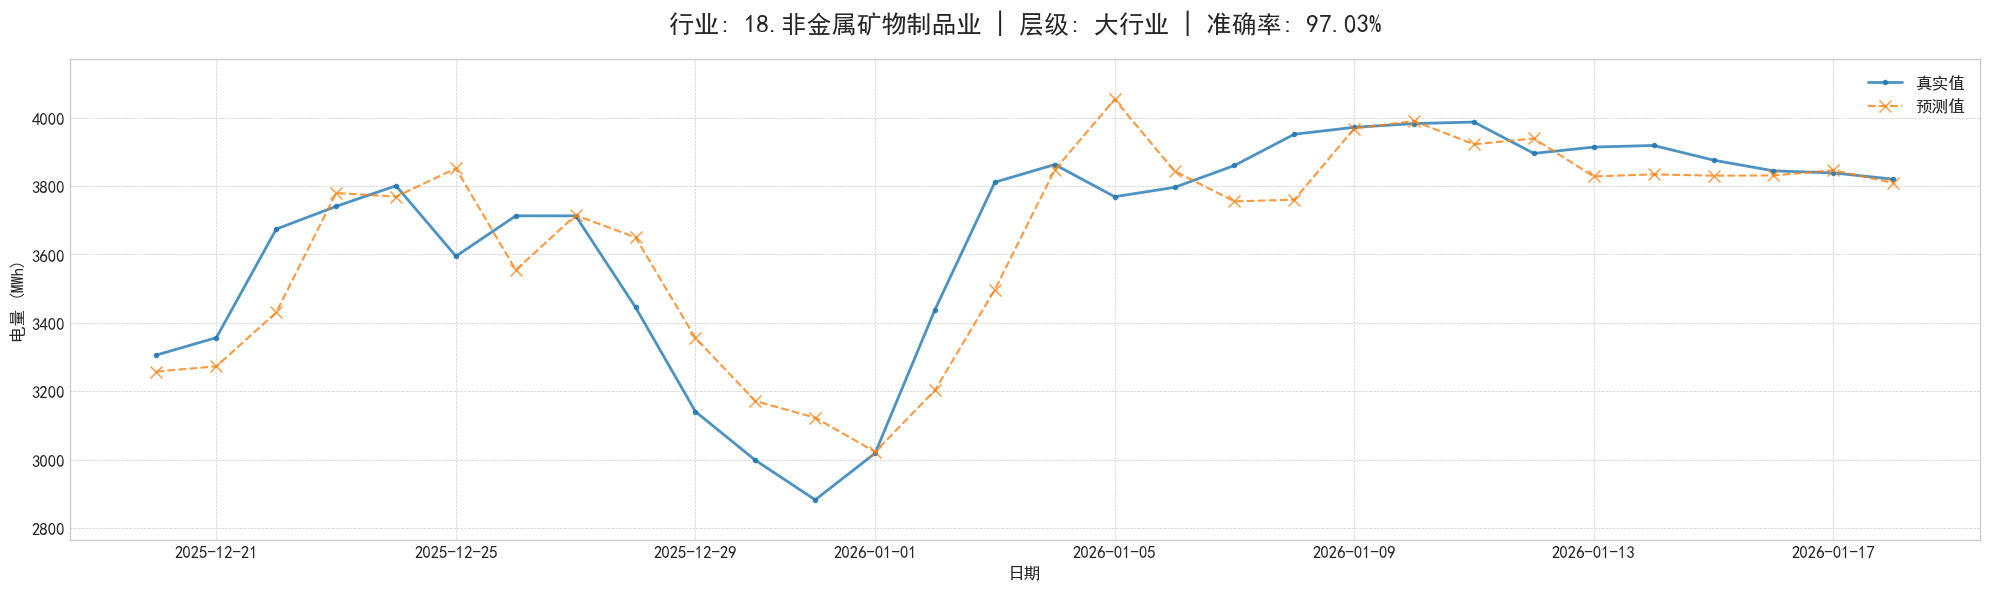

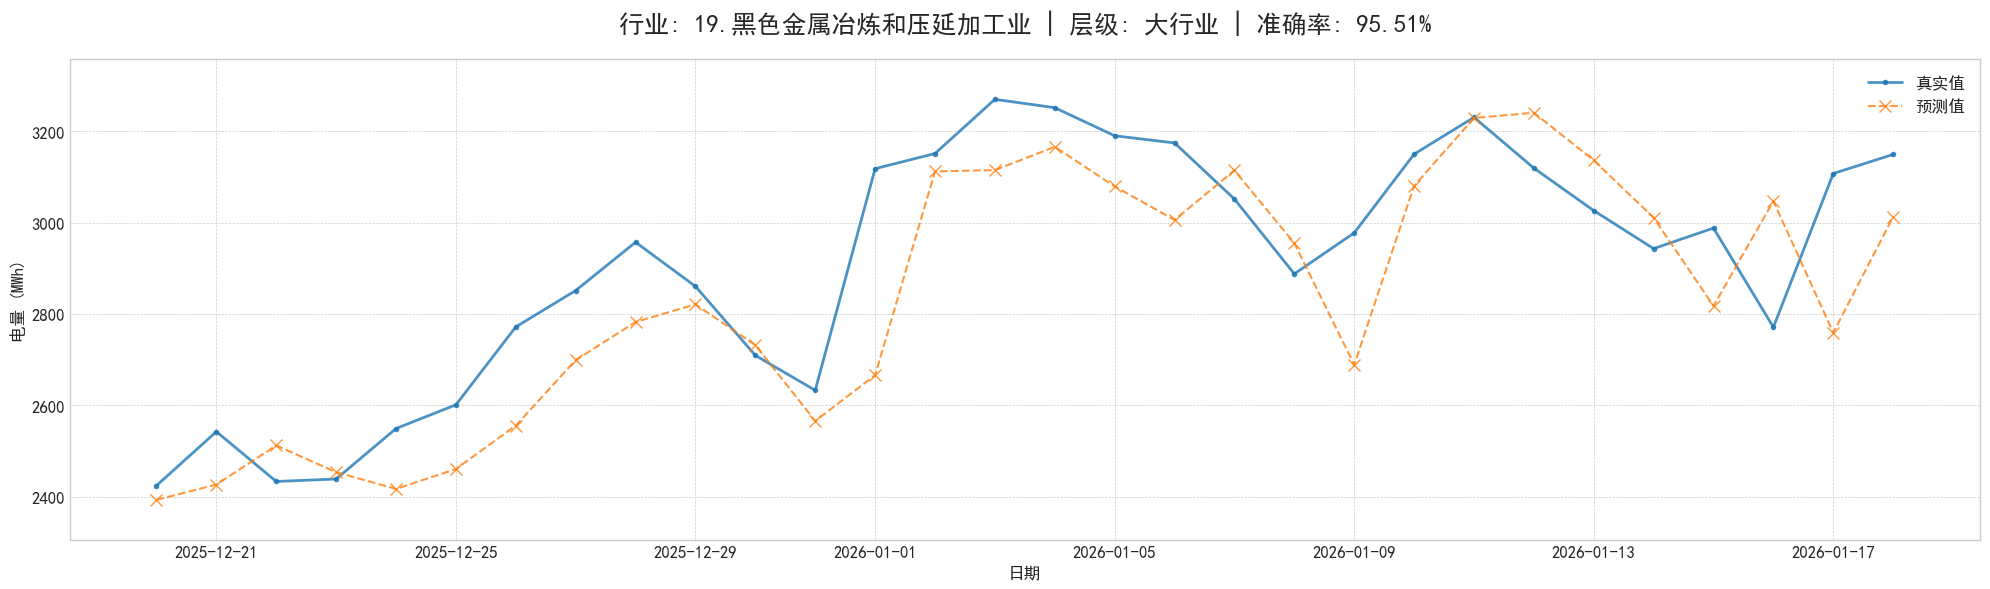

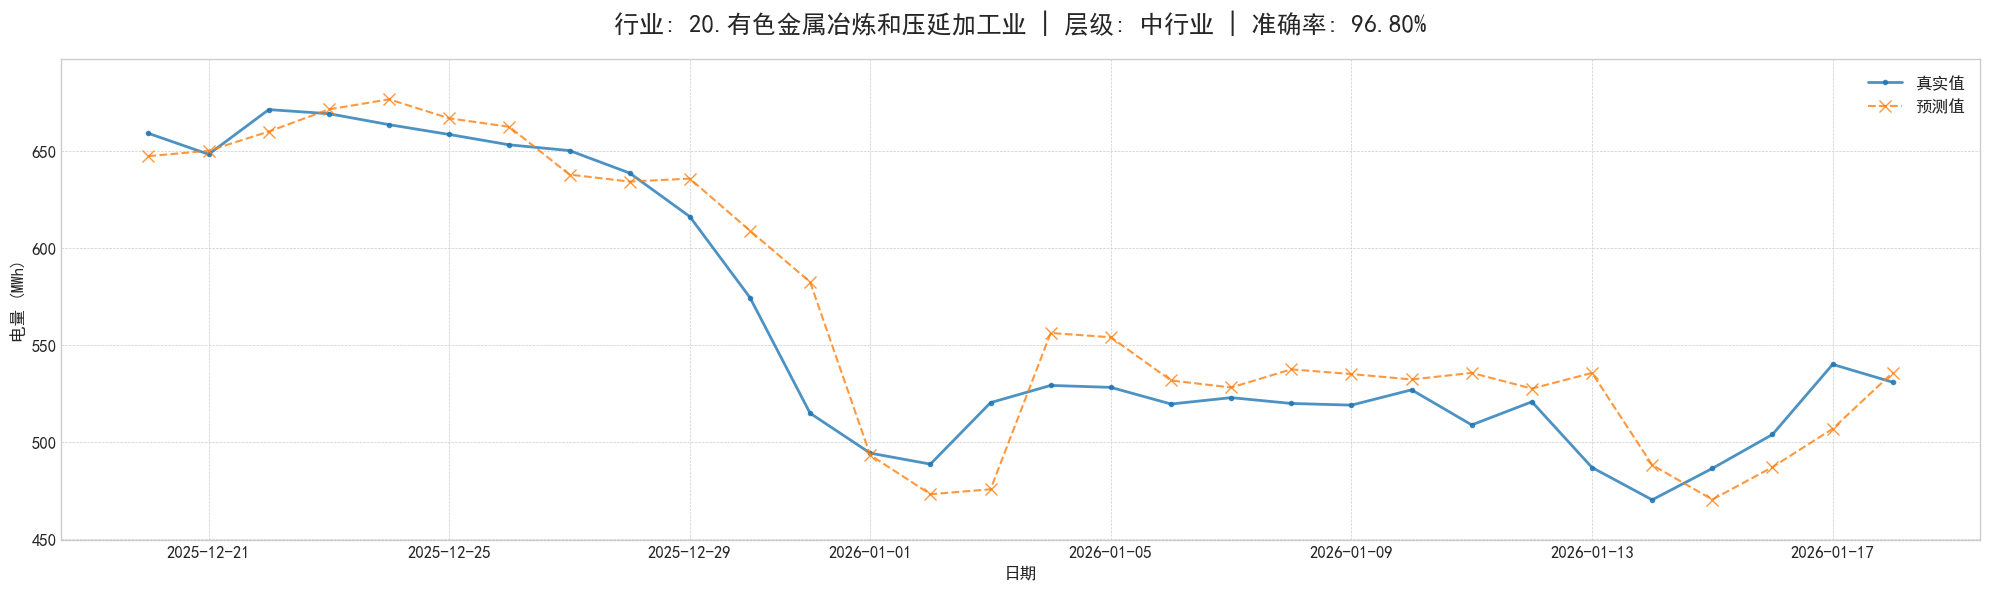

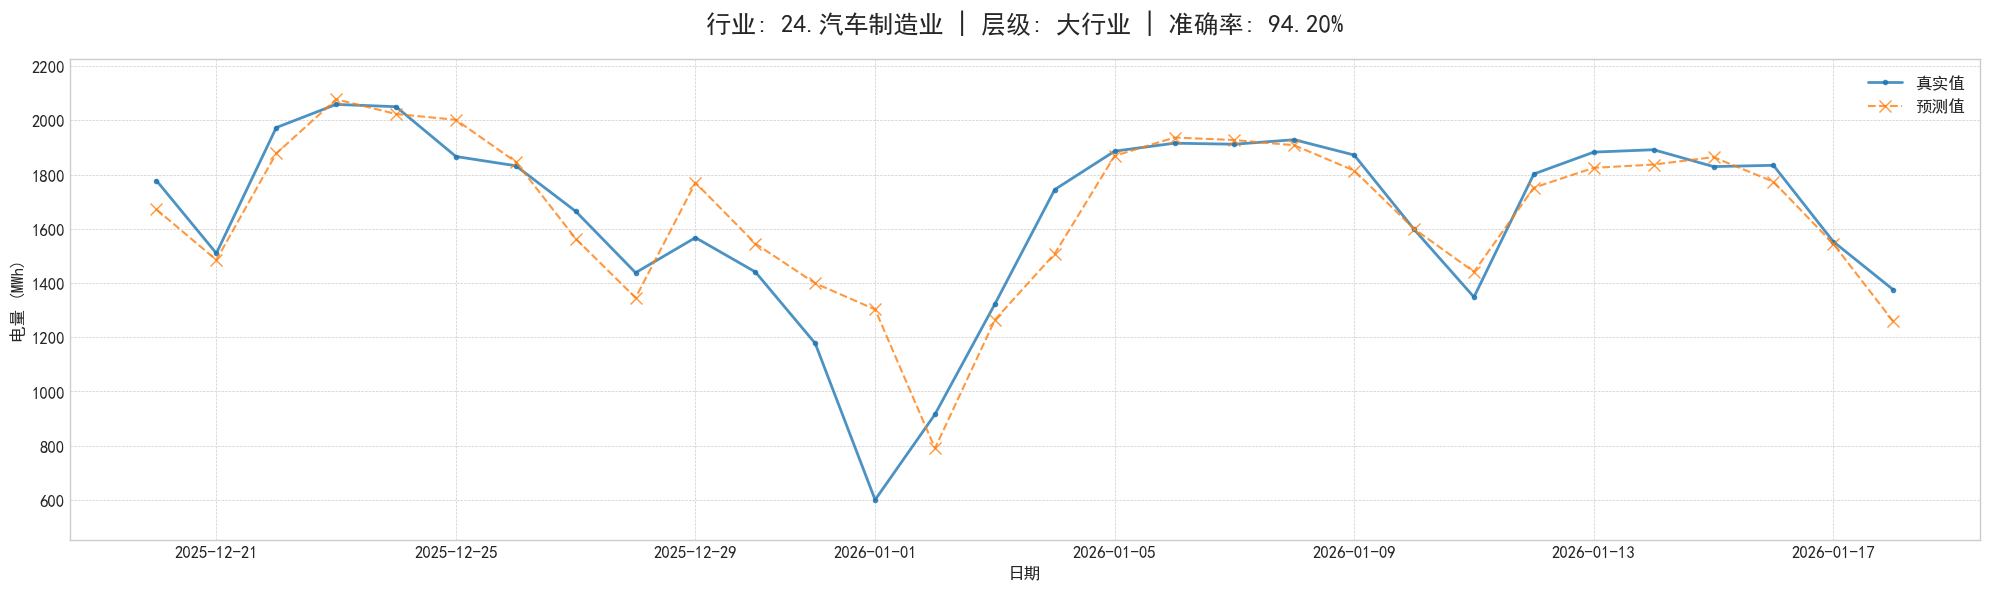

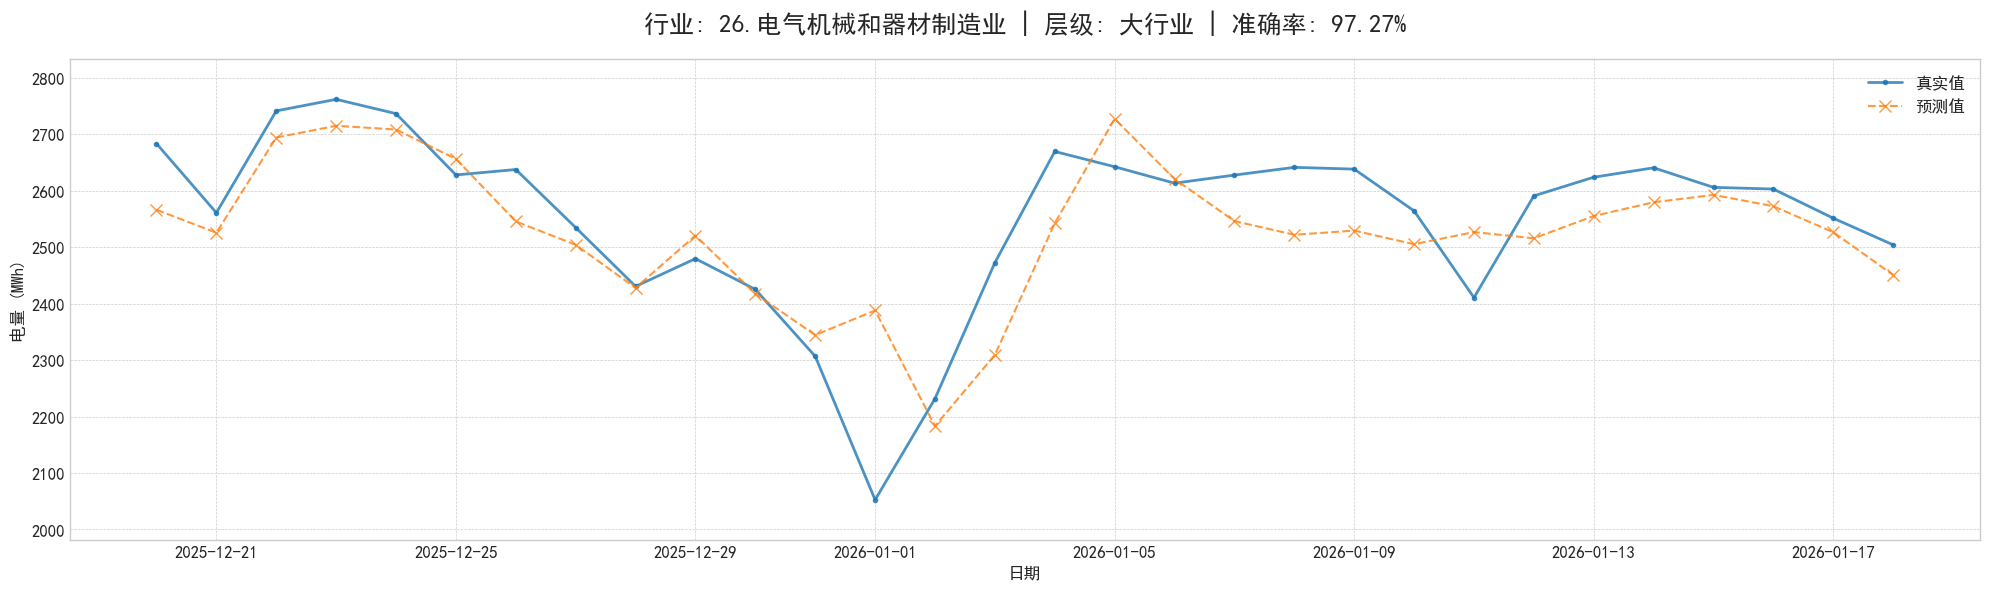

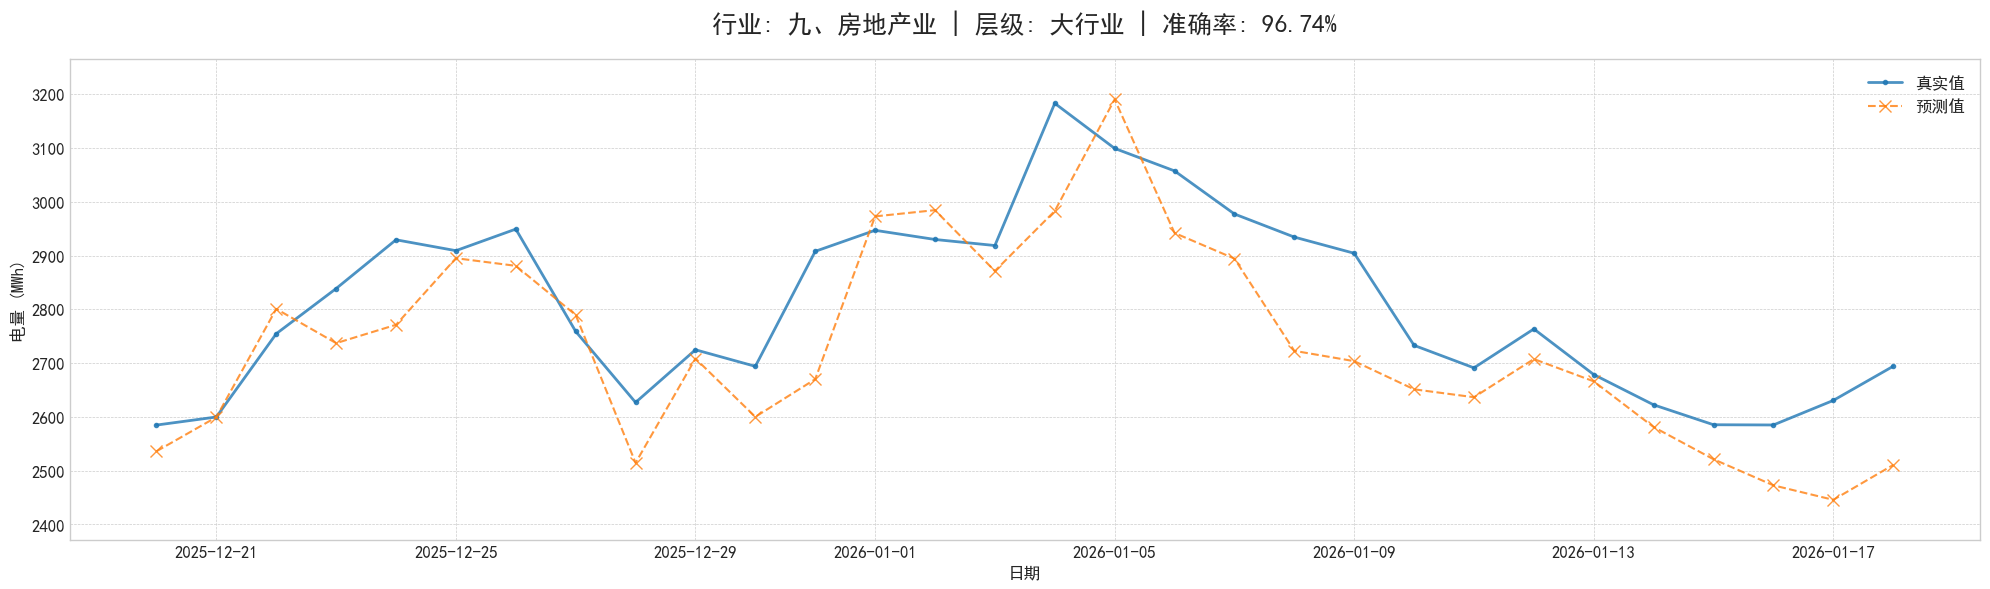

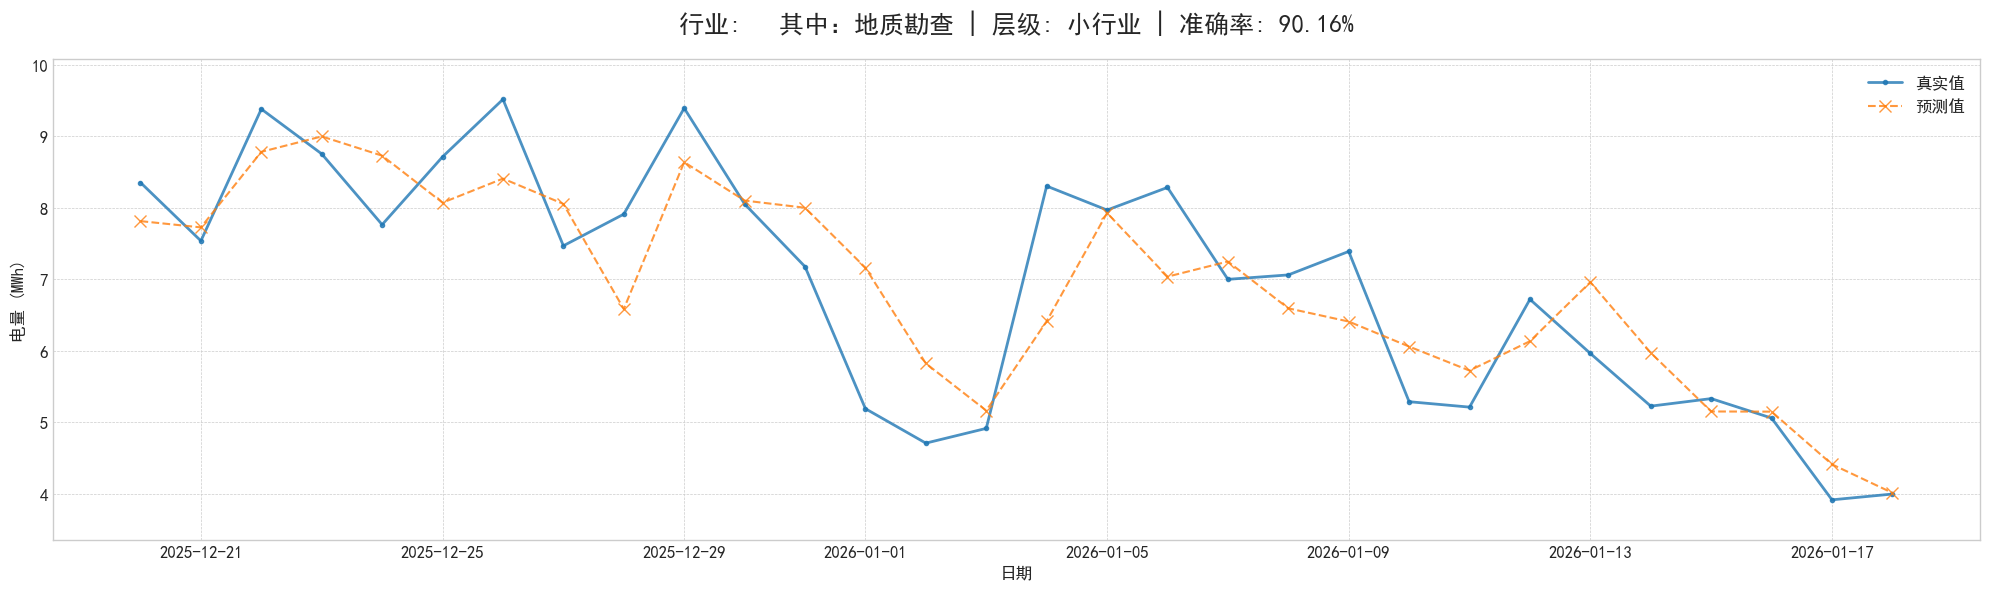

In [10]:
# ==============================================================================
# 模块八 (优化版): 重点行业可视化评估与准确率计算
# ==============================================================================

# 确认包含所有预测结果的DataFrame 'final_test_df' 已经创建
if 'final_test_df' in locals() and not final_test_df.empty:

    # --- 1. 定义您重点关注的行业列表 ---
    key_industries = [
        "客户用电量",
        "A、全行业用电合计",
        "    第二产业",
        "    第三产业",
        "B、城乡居民生活用电合计",
        "14.化学原料和化学制品制造业",
        "15.医药制造业",
        "18.非金属矿物制品业",
        "19.黑色金属冶炼和压延加工业",
        "20.有色金属冶炼和压延加工业",
        "24.汽车制造业",
        "26.电气机械和器材制造业",
        "九、房地产业",
        "  其中：地质勘查"
    ]
    
    # 检查您关注的行业是否都存在于测试集中
    missing_industries = [ind for ind in key_industries if ind not in final_test_df['行业名称'].unique()]
    if missing_industries:
        print(f"\n警告：以下您关注的行业在测试集中不存在，将被忽略: {missing_industries}")
        key_industries = [ind for ind in key_industries if ind in final_test_df['行业名称'].unique()]

    # --- 2. 为重点行业计算详细的评估指标 ---
    print("\n" + "="*80)
    print("      重点行业性能评估报告 (含准确率)")
    print("="*80)
    
    metrics_list = []
    TARGET = 'load_MWh' # 确保目标列名正确

    for industry in key_industries:
        subset = final_test_df[final_test_df['行业名称'] == industry].copy()
        if subset.empty: continue
            
        true_values = subset[TARGET]
        pred_values = subset['prediction']
        
        # 基础指标
        mae = mean_absolute_error(true_values, pred_values)
        rmse = np.sqrt(mean_squared_error(true_values, pred_values))
        avg_load = true_values.mean()
        
        # MAPE (处理分母为0的情况)
        non_zero_mask = true_values != 0
        mape = np.nan if not np.any(non_zero_mask) else mean_absolute_percentage_error(true_values[non_zero_mask], pred_values[non_zero_mask])
        
        # 【核心新增】计算准确率 (1 - WMAPE)
        # WMAPE = MAE / Mean_Actual
        # 这是电力行业常用的准确率定义，比MAPE更适合处理波动大的负荷
        wmape = mae / avg_load if avg_load != 0 else np.nan
        accuracy = 1 - wmape

        metrics_list.append({
            '行业名称': industry,
            '所属模型层级': subset['tier'].iloc[0],
            '日均用电量': avg_load,
            '平均绝对误差 (MAE)': mae,
            '均方根误差 (RMSE)': rmse,
            'MAPE': mape,
            '准确率 (1-WMAPE)': accuracy # 新增指标
        })

    df_key_metrics = pd.DataFrame(metrics_list).set_index('行业名称')
    
    # 打印格式化的表格
    pd.options.display.float_format = '{:,.2f}'.format
    # 设置显示格式，重点突出准确率
    print(df_key_metrics.to_string(formatters={
        'MAPE': '{:,.2%}'.format,
        '准确率 (1-WMAPE)': '{:,.2%}'.format # 百分比显示
    }))
    
    # --- 3. 为每个重点行业绘制高质量的预测对比图 ---
    print("\n--- 重点行业预测结果可视化 ---")
    
    for industry in key_industries:
        # 确保按时间排序，防止画图乱序
        subset = final_test_df[final_test_df['行业名称'] == industry].sort_values('date')
        if subset.empty: continue
            
        # 获取该行业的准确率，用于标题展示
        acc_val = df_key_metrics.loc[industry, '准确率 (1-WMAPE)']
        
        fig, ax = plt.subplots(figsize=(20, 6))
        
        ax.plot(subset['date'], subset[TARGET], label='真实值', marker='.', linestyle='-', linewidth=2, alpha=0.8)
        ax.plot(subset['date'], subset['prediction'], label='预测值', marker='x', linestyle='--', markersize=8, alpha=0.8)
        
        # 标题中加入准确率信息
        ax.set_title(f"行业: {industry} | 层级: {subset['tier'].iloc[0]} | 准确率: {acc_val:.2%}", fontsize=18, pad=20)
        ax.set_xlabel('日期', fontsize=12)
        ax.set_ylabel('电量 (MWh)', fontsize=12)
        
        ax.legend(fontsize=12, loc='upper right')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # 动态调整Y轴范围，让图表更好看
        y_min = min(subset[TARGET].min(), subset['prediction'].min())
        y_max = max(subset[TARGET].max(), subset['prediction'].max())
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
        
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

else:
    print("错误：未能找到名为 'final_test_df' 的DataFrame。请确保您已经成功运行了模型分层的训练代码块。")

In [30]:
# ==============================================================================
# 模块八 (修正版)：未来递归预测函数 (支持指定行业 & 全量历史)
# ==============================================================================

def predict_future(full_history_df, days_to_predict, models, industry_tiers, sensitivity_df, df_weather_source, target_industries=None):
    """
    使用分层模型，对未来N天的指定行业电量进行递归预测。

    参数:
    - full_history_df: DataFrame, 【必须是全量历史数据】(包含 'date', '行业名称', 'load_MWh')。
    - days_to_predict: int, 预测未来天数。
    - models: dict, 训练好的模型字典。
    - industry_tiers: DataFrame, 行业层级信息。
    - sensitivity_df: DataFrame, 敏感度信息。
    - df_weather_source: DataFrame, 天气数据。
    - target_industries: list, 【新增】指定要预测的行业名称列表。如果为None，则预测所有。

    返回:
    - DataFrame, 包含未来预测结果。
    """
    
    # --- 0. 筛选目标行业 ---
    if target_industries is not None:
        # 筛选历史数据，只保留我们关心的行业，减少计算量
        historical_df = full_history_df[full_history_df['行业名称'].isin(target_industries)].copy()
        unique_industries = target_industries
        print(f"已筛选 {len(unique_industries)} 个目标行业进行预测。")
    else:
        historical_df = full_history_df.copy()
        unique_industries = historical_df['行业名称'].unique()
        print(f"未指定目标行业，将预测所有 {len(unique_industries)} 个行业。")

    if historical_df.empty:
        print("错误：筛选后的历史数据为空，请检查行业名称是否正确。")
        return pd.DataFrame()

    # --- 1. 准备时间范围 ---
    last_known_date = historical_df['date'].max()
    start_date = last_known_date + pd.DateOffset(days=1)
    future_dates = pd.date_range(start=start_date, periods=days_to_predict, freq='D')
    
    print(f"\n" + "="*60)
    print(f"      预测配置确认")
    print(f"      数据截止日期: {last_known_date.date()}")
    print(f"      预测开始日期: {start_date.date()}")
    print(f"      预测结束日期: {future_dates[-1].date()}")
    print(f"      预测总天数  : {days_to_predict} 天")
    print("="*60)

    # --- 2. 扩展天气数据 ---
    if future_dates[-1] not in df_weather_source.index:
        print("警告: 天气数据未覆盖预测期，使用最后已知天气前向填充...")
        future_weather_idx = pd.date_range(start=df_weather_source.index.max() + pd.DateOffset(days=1), 
                                           end=future_dates[-1], freq='D')
        last_weather = df_weather_source.iloc[[-1]]
        future_weather = pd.concat([last_weather] * len(future_weather_idx))
        future_weather.index = future_weather_idx
        df_weather_extended = pd.concat([df_weather_source, future_weather])
    else:
        df_weather_extended = df_weather_source.copy()

    # --- 3. 构建未来数据的骨架 ---
    future_df = pd.DataFrame([
        {'date': date, '行业名称': industry}
        for date in future_dates
        for industry in unique_industries
    ])
    future_df['load_MWh'] = np.nan
    
    # --- 4. 合并静态属性 ---
    # 确保 tier 和 sensitivity 覆盖了目标行业
    future_df = pd.merge(future_df, industry_tiers[['tier']], on='行业名称', how='left')
    future_df['tier'] = future_df['tier'].fillna('小行业')
    
    future_df = pd.merge(future_df, sensitivity_df[['sensitivity']], on='行业名称', how='left')
    future_df['sensitivity'] = future_df['sensitivity'].fillna('低敏感')

    # --- 5. 拼接历史数据 ---
    # 只取最近60天历史用于特征计算
    lookback_days = 60 
    history_subset = historical_df[historical_df['date'] >= last_known_date - pd.DateOffset(days=lookback_days)].copy()
    
    # 补全历史数据的静态特征
    if 'sensitivity' not in history_subset.columns:
        history_subset = pd.merge(history_subset, sensitivity_df[['sensitivity']], on='行业名称', how='left')
    if 'tier' not in history_subset.columns:
        history_subset = pd.merge(history_subset, industry_tiers[['tier']], on='行业名称', how='left')

    full_df = pd.concat([history_subset, future_df], ignore_index=True)
    full_df = full_df.sort_values(by=['行业名称', 'date']).reset_index(drop=True)

    # --- 6. 逐日递归预测 ---
    for i, current_date in enumerate(future_dates):
        print(f"[{i+1}/{days_to_predict}] 正在预测: {current_date.date()} ...")
        
        # A. 特征工程
        df_features = create_panel_features_ultimate(full_df, df_weather_extended)
        
        # B. 筛选当天数据
        current_day_data = df_features[df_features['date'] == current_date].copy()
        
        # C. 分层预测
        for tier_name, model in models.items():
            tier_mask = (current_day_data['tier'] == tier_name)
            if tier_mask.sum() == 0: continue
                
            features_needed = model.feature_name_
            
            # 缺失特征补0
            for c in features_needed:
                if c not in current_day_data.columns: current_day_data[c] = 0
            
            X_pred = current_day_data.loc[tier_mask, features_needed]
            y_pred = model.predict(X_pred)
            
            # D. 回填预测值
            target_inds = current_day_data.loc[tier_mask, '行业名称'].values
            condition = (full_df['date'] == current_date) & (full_df['行业名称'].isin(target_inds))
            full_df.loc[condition, 'load_MWh'] = y_pred

    # --- 7. 返回结果 ---
    final_result = full_df[full_df['date'] > last_known_date][['date', '行业名称', 'load_MWh', 'tier']].copy()
    final_result.rename(columns={'load_MWh': 'predicted_load'}, inplace=True)
    
    print("\n预测完成！")
    return final_result

In [ ]:
# ==============================================================================
# 调用示例
# ==============================================================================

# 1. 定义你想预测的行业列表
MY_TARGET_INDUSTRIES = [
    "客户用电量",
    "    第二产业",
    "    第三产业",
    "B、城乡居民生活用电合计"
    # ... 在这里添加你需要的其他行业
]

# 2. 确保使用全量数据 df_main
if 'df_main' in locals() and 'final_models' in locals():
    
    # 设定预测天数 (例如预测未来 7 天)
    DAYS_TO_PREDICT = 7  
    
    # 运行预测
    future_predictions = predict_future(
        full_history_df=df_main,       # <--- 关键：这里要传 df_main (包含到2026.1.18的数据)
        days_to_predict=DAYS_TO_PREDICT,
        models=final_models,
        industry_tiers=industry_avg_load,
        sensitivity_df=sensitivity_df,
        df_weather_source=df_weather_full,
        target_industries=MY_TARGET_INDUSTRIES # <--- 关键：传入你的目标行业列表
    )
    
    print("\n预测结果预览:")
    print(future_predictions.head())
    
    # 保存结果
    future_predictions.to_csv(r"E:\A智网\电量预测数据\lightgbm模型\目标行业未来预测结果.csv", index=False, encoding='utf_8_sig')
    print("结果已保存至 '目标行业未来预测结果.csv'")

else:
    print("错误：缺少必要的变量 (df_main 或 final_models)。请确保前面的模块已运行。")

已筛选 4 个目标行业进行预测。

      预测配置确认
      数据截止日期: 2026-01-25
      预测开始日期: 2026-01-26
      预测结束日期: 2026-02-01
      预测总天数  : 7 天
[1/7] 正在预测: 2026-01-26 ...

--- 正在执行终极版特征工程 (含手动节假日修正) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！
[2/7] 正在预测: 2026-01-27 ...

--- 正在执行终极版特征工程 (含手动节假日修正) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！
[3/7] 正在预测: 2026-01-28 ...

--- 正在执行终极版特征工程 (含手动节假日修正) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！
[4/7] 正在预测: 2026-01-29 ...

--- 正在执行终极版特征工程 (含手动节假日修正) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！
[5/7] 正在预测: 2026-01-30 ...

--- 正在执行终极版特征工程 (含手动节假日修正) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！
[6/7] 正在预测: 2026-01-31 ...

--- 正在执行终极版特征工程 (含手动节假日修正) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！
[7/7] 正在预测: 2026-02-01 ...

--- 正在执行终极版特征工程 (含手动节假日修正) ---
正在创建历史和日历相关特征...
正在创建【交互式】的真实未来天气特征...
交互式未来天气特征创建完成！

预测完成！

预测结果预览:
         date      行业名称  predicted_load tier
61 2026-01-26      第三产业